---
authors:
  - name: Alexandre René
math:
  '\sinf' : '{s_{\infty}}'
  '\Vpre' : '{V_{\mathrm{pre}}}'
  '\Vpost': '{V_{\mathrm{post}}}'
  '\Vth'  : '{V_{\mathrm{th}}}'
  '\km'   : '{k_{-}}'
  
  '\AB'  : '{\mathrm{AB}}'
  '\PD'  : '{\mathrm{PD}}'
  '\LP'  : '{\mathrm{LP}}'
  '\PY'  : '{\mathrm{PY}}'
  
  '\Na'  : '{\mathrm{Na}}'
  '\Ca'  : '{\mathrm{Ca}}'
  '\CaT' : '{\mathrm{CaT}}'
  '\CaS' : '{\mathrm{CaS}}'
  '\A'   : '{\mathrm{A}}'
  '\KCa' : '{\mathrm{K(Ca)}}'
  '\Kd'  : '{\mathrm{Kd}}'
  '\H'   : '{\mathrm{H}}'
  '\leak': '{\mathrm{leak}}'
  
  '\actfn': '{\frac{#1}{1+\exp\left(\frac{#2}{#3}\right)}}'
  
  '\logit': '\mathop{\mathrm{logit}}'
---

(code_pyloric-circuit-implementation)=
# Pyloric network simulator

:::{only} html
%{{ startpreamble }}
%{{ endpreamble }}
:::

> **NOTE** Within Jupyter Lab, this notebook is best displayed with [`jupyterlab-myst`](https://myst-tools.org/docs/mystjs/quickstart-jupyter-lab-myst).

This is an implementation of the three-cell model of crustacean stomatogastric ganglion described in {cite:t}`marderModelingSmallNetworks1998` and used by {cite:t}`prinzSimilarNetworkActivity2004` to demonstrate that disparate parameter sets lead to comparable network activity. The main features of this particular implementation are:

JAX-accelerated Python implementation
~ Combines the flexibility of Python with the speed of compiled JAX code.
~ The specification of update equations for ion channels was carefully designed to maximize vectorization.

Choice of ODE solver
~ The official C++ implementation uses hard-coded Euler integration, which can make it vulnerable to numerical instabilities. (Neuron conductance-based models, after all, are stiff by design.)
~ In contrast, this implementation is designed to be used with Python’s ODE solvers, making it easy to use a more appropriate solver. In particular, adaptive step solvers can dramatically reduce simulation time, while still keeping enough time precision to resolve spikes.

Modularity
~ New cell types are defined simply by extending Python arrays for the ion channel parameters.  
  If needed, an arbitrary function can also be given for specific ion channels.

Flexibility
~ You are not limited to the published three-cell network: studying a smaller two-cell network, or a larger one with different LP cells, is a simple matter of changing three arrays.

All-in-one documentation
~ The original specification of the pyloric circuit model is spread across at least three resources[^model-def].  
  Here all definitions are included in the inlined documentaiton, are fully referenced and use consistent notation.

Single source of truth
~ Both the documentation and the code use the same source for parameter values, so you can be sure the documentated values are actually those used in the code. 
~ In cases where this was not practical, Python values are specified with a string identical to the source of the documentation’s Markdown table.
  Agreement between documentation and code can be checked at any time by [“diff”-ing](https://linuxhandbook.com/diff-command/) the markdown and Python code blocks, or copy-pasting one onto the other.

[^model-def]: Original references for the pyloric circuit model:  
    • Prinz, A. A., Bucher, D. & Marder, E. *Similar network activity from disparate circuit parameters.* Nature Neuroscience 7, 1345–1352 (2004). [doi:10.1038/nn1352](https://doi.org/10.1038/nn1352)  
    • Prinz, A. A., Billimoria, C. P. & Marder, E. *Alternative to Hand-Tuning Conductance-Based Models: Construction and Analysis of Databases of Model Neurons.*
      Journal of Neurophysiology 90, 3998–4015 (2003). [doi:10.1152/jn.00641.2003](https://doi.org/10.1152/jn.00641.2003)  
    • Marder, E. & Abbott, L. F. *Modeling small networks.* in Methods in neuronal modeling: from ions to networks (eds. Koch, C. & Segev, I.) (MIT Press, 1998).

In [1]:
from __future__ import annotations

In [2]:
import logging
import shelve
import re
import numpy as np
import pandas as pd
import holoviews as hv

from ast import literal_eval
from collections import namedtuple
from collections.abc import Sequence
from dataclasses import dataclass
from datetime import timedelta
from functools import partial
from pathlib import Path
from typing import Union, Type, Generator, Callable, Tuple, ClassVar
from flufl.lock import Lock
from numpy import exp
from numpy.typing import ArrayLike
from scipy import integrate
from addict import Dict

from scityping.numpy import Array

logger = logging.getLogger(__name__)

In [3]:
from config import config
try:
    import jax
    from jax import config as jax_config; jax_config.update("jax_enable_x64", True); del jax_config
    import jax.numpy as jnp
except ImportError:
    import jax_shim as jax
    import jax_shim.numpy as jnp

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
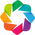

In [4]:
from myst_nb import glue
import pint
ureg = pint.get_application_registry()
Q_ = ureg.Quantity

from scipy import integrate
hv.extension("matplotlib", "bokeh")

from jb_fixes import display_dataframe_with_math
# Notebook-only imports

In [6]:
__all__ = ["Prinz2004", "State", "SimResult", "neuron_models", "dims"]

## Usage example

In [ ]:
import holoviews as hv
from pyloric_network_simulator.prinz2004 import Prinz2004, neuron_models, dims
hv.extension("bokeh")  # Bokeh plots allow to zoom in on the trace much more easily

Instantiate a new model by specifying:

- The number of neurons of each type (PD, AB, LP and PY)
- The connectivity `gs` between populations
- The set of membrane conductances for each type `g_cond`.  
  The 16 sets which define the neuron models used in {cite:t}`prinzSimilarNetworkActivity2004` are provided in `neuron_models`.

:::{margin}
If ion channel conductivities are not specified explicitely specified, `Prinz2004` will use the values for the models
matching the keys of `pop_sizes`, so this also works:

```python
model = Prinz2004(pop_sizes = {"PD 1": 2, "AB 1": 1, "LP 1": 1, "PY 1": 5},
                  gs      = [ [    0  ,     0  ,     3  ,     0 ],
                              [    0  ,     0  ,     3  ,     3 ],
                              [    3  ,     3  ,     0  ,     3 ],
                              [    3  ,     3  ,     3  ,     0 ] ]
                  )
```

This form is more compact, but of course is limited to those neuron models listed in `prinz_model.g_cond` and it is not possible to omit the neuron model number in the keys of `pop_sizes`.
:::

In [ ]:
# Note that cholinergic (PD) and glutamatergic (AB, LP, PY) neurons are contiguous.
# This allows the model to use more efficient indexing based on slices,
# instead of slower indexing arrays.
# `pop_size` keys should match one of the four type labels (AB, PD, LP, PY) or the
# combined label "AB/PD". If there are multiple neurons of one type, they can be
# followed by a number: "AB 1", "AB 2", ...
# IMPORTANT: The `Prinz2004` class uses regular expressions on these labels to determine
# the right type of connectivity, so they must follow this labelling pattern exactly.
model = Prinz2004(pop_sizes = {"PD": 2, "AB": 1, "LP": 1, "PY": 5},
                  gs      = [ [    0  ,     0  ,     3  ,     0 ],
                              [    0  ,     0  ,     3  ,     3 ],
                              [    3  ,     3  ,     0  ,     3 ],
                              [    3  ,     3  ,     3  ,     0 ] ],
                  g_ion = neuron_models.loc[["AB/PD 1", "AB/PD 1", "LP 1", "PY 1"]]  # May be specified as DataFrame or Array
                  )

Define a set of time points and evaluate the model at those points.
A model simulation is always initialized with the result of a cached warm-up simulation (see [Initialization](sec-initialization)). If no such simulation matching the model parameters is found in the cache, it is performed first and cached for future runs.

The example below reproduces the procedure of {cite:t}`prinzSimilarNetworkActivity2004`: After neurons are connected, an initial simulation of 3s is thrown away to let transients decay. Then 1s is simulated to generate the data for that network model.

:::{note}
:class: margin
The time points we provide to `model` are only those which are recorded; they have no bearing on the integration time step.[^very-small-steps] To resolve spikes, a time resolution of 1 ms or less is needed.
:::

[^very-small-steps]: For deterministic systems, integration is performed using a Runge-Kutta 4(5) scheme with adaptive time step, which can number in the 100’s or more time steps per millisecond. If we recorded all of these we would quickly exceed memory limits.

In [ ]:
# Generate 1001 sequential time points (3000–4000), and evaluate the model at those points
res = model(np.linspace(3000, 4000, 1001))

Results are returned as a [`SimResult`](simresult-object) object, which has attributes to retrieve the different traces: membrane voltage `V`, calcium concentration `Ca`, synaptic activation `s`, membrane activation `m` and membrane inactivation `h`.
These are returned as Pandas DataFrames.
:::{admonition} TODO
:class: caution, margin
The `m` and `h` variables for now are still returned as plain arrays.
:::

In [ ]:
# Retrieve trace for one neuron per population
Vtraces = res.V.loc[:,[("AB", 1), ("LP", 1), ("PY", 1)]].droplevel("index", axis="columns")
# In addition to voltage, the following time-dependent variables are also available:
res.Ca  # Intracellular calcium concentration  (n_time_bins x n_neurons)
res.s   # Synapse activation                   (n_time_bins x n_neurons)
res.m   # Channel activation                   (n_time_bins x n_channels x n_neurons)
res.h   # Channel inactivation                 (n_time_bins x n_channels x n_neurons)
# A plain time-bin array can also be retrieved
res.t

For simple plots, one can use the DataFrame `plot` method directly.
For more complex plots, it is often more convenient to retrieve the data and call the plotting functions directly.

In [ ]:
Vtraces.plot("AB")  # Simple plot using the DataFrame method
# Call plotting functions directly after retrieving data
hv.Curve(Vtraces.loc[:,"AB"]) + hv.Curve(Vtraces.loc[:,"LP"]) + hv.Curve(Vtraces.loc[:,"PY"])

To inspect the initialization curves, we use the private method [`thermalize`](prinz2004-object); this is used internally to generate the thermalized state. It returns a [`SimResult`](simresult-object) object.
(NB: Since during thermalization, we disconnect all neurons to get each’s individual spontaneous activity, it is only necessary to simulate one neuron per population. This is why the result returned by `thermalize` always has population sizes of 1.)

In [ ]:
res = model.thermalize()
Vtraces = res.V.droplevel("index", axis="columns")  # The initialization run has only one neuron per pop, since they are identical

hv.output(backend="bokeh")  # Workaround: If we don’t switch the default, Bokeh ignores the new colors
ov = hv.Overlay([hv.Curve(Vtraces.loc[:,pop_name], label=pop_name)
                 for i, pop_name in enumerate(model.pop_model_list)]) \
     .opts(ylabel="voltage (mV)") \
     .redim(time=dims.t)
# Assign trace colours
for pop_name, c in zip(res.pop_slices, hv.Cycle("Dark2").values):
    ov.opts(hv.opts.Curve(f"Curve.{hv.core.util.sanitize_identifier_fn(pop_name)}", color=c))
ov.opts(width=800, legend_position="right", backend="bokeh")

## Definitions

In [ ]:
def list_table_iter(text_data: str) -> Generator[list, None, None]:
    """
    Take a string in the {list-table} format, and return an iterator
    which aggregates table lines.
    """
    table_line = []
    for line in text_data.split("\n"):
        if line.startswith("*"):
            #table_line = list(filter(None, table_line))  # Remove blank columns
            if table_line:  # Remove blank lines
                yield table_line
            table_line = [line.strip(" -*")]
        else:
            if line.strip().startswith("-"):  # New column
                table_line.append(line.strip(" -"))
            elif table_line: # Continued column; this condition can only be False if the data starts with empty lines
                table_line[-1] += "\n" + line
    #table_line = list(filter(None, table_line))  # Remove blank columns
    if table_line:
        yield table_line

def parse_list_table(text_data, stub_columns: int=0, header_rows: int=0, eval_values: bool=True, filler=None):
    """
    Returns: data, stubs, headers
    """
    it = list_table_iter(text_data)
    # Parse header lines
    headers = [line for _, line in zip(range(header_rows), it)]  # range() must come before `it`, so that we don’t draw an extra line
    # Parse data lines
    stubs = []
    data = []
    for line in it:
        stubs.append(line[:stub_columns])
        if eval_values:
            data.append([literal_eval(v) for v in line[stub_columns:]])
        else:
            data.append(line[stub_columns:])
    headers = [line[stub_columns:] for line in headers]
    # Normalize shape
    if header_rows == 1:
        headers = headers[0]
    if stub_columns == 1:
        stubs = [line[0] for line in stubs]
    ncols = max(len(row) for row in data)
    data = [row + [None]*(ncols-len(row)) for row in data]

    return data, stubs, headers

In [ ]:
def align_sep(precision: int) -> Callable[[float], str]:
    """
    Return a formatter function for which the values will roughly align along the separator.
    Alignment is exact only when used with a fixed-width font.
    Used to align values in a Pandas DataFrame.
    """
    def f(v):
        if v == np.inf:
            return "∞" + "&nbsp;"*(precision+1)
        elif v == int(v):
            return str(int(v)) + "&nbsp;"*(precision+1)  # +1 to account for decimal separator
        else:
            s = f"{v:.{precision}f}"
            l = len(s)-1; i = l;
            while s[i] == "0":
                i -= 1
            return s[:i+1] + "&nbsp;"*(l-i)
    return f

In [ ]:
# IMPORTANT: List orders must be kept consistent, because for efficiency the
#            implementation uses plain arrays, vectorized ops and indexing by position
act_varnames = ["minf", "hinf", "taum", "tauh"]
channels     = ["INa", "ICaT", "ICaS", "IA", "IKCa", "IKd", "IH"]
neuron_types = ["PD", "AB", "LP", "PY"]  # Putting PD first allows us to have all glutamatergic neurons in one contiguous slice
neuron_pops  = ["AB/PD", "LP", "PY"]

dims = dict(
    minf = r"$m_\infty$",
    hinf = r"$h_\infty$",
    taum = r"$τ_m$",
    tauh = r"$τ_h$",
    INa  = r"$I_\mathrm{Na}$",
    ICaT = r"$I_\mathrm{CaT}$",
    ICaS = r"$I_\mathrm{CaS}$",
    IA   = r"$I_\mathrm{A}$",
    IKCa = r"$I_\mathrm{K(Ca)}$",
    IKd  = r"$I_\mathrm{Kd}$",
    IH   = r"$I_\mathrm{H}$",
    V    = r"$V$",
    
    Es   = r"$E_\mathrm{s}$",
    km   = r"$k_{-}$",
    Vth  = r"$V_{\mathrm{th}}$",
    Δ    = r"$\Delta$",
    
    t    = "time"
)
dims = Dict({nm: hv.Dimension(nm, label=label) for nm, label in dims.items()})

dims.V.unit = "mV"
dims.t.unit = "ms"

## Single compartment conductance model

The conductance model is described in {cite:t}`prinzAlternativeHandTuningConductanceBased2003` (p.1-2, §*Model*).
Where differences in notation occur, we prefer those in {cite:t}`prinzSimilarNetworkActivity2004`.

In the equations, $I_i$ is the current for each channel, while $I_{\mathrm{input}}$ is the current from synaptic inputs $I_e$ and $I_s$. These are computed using the [electrical](sec_elec-synapse-model) and [chemical](sec_chem-synapse-model) synapse models defined below.
We also allow for an additional external input current $I_{\mathrm{ext}}$; this current is not necessary to drive the system (after all, a defining feature of the pyloric circuit is its spontaneous rhythm). Expected magnitudes for $I_{\mathrm{ext}}$ are 3–6 $\mathrm{nA}$.[^loose-units]

[^loose-units]: Strictly speaking, the units of $I$ are actually $\mathrm{nA}/\mathrm{cm}^2$; reporting $I$ in units of $\mathrm{nA}$ implies the convention $C/A = 1$. A more correct, although less conventional, reporting of this magnitude would be $I_{\mathrm{ext}} \frac{A}{C} = $ 3–6 $\mathrm{mV}/\mathrm{ms}$.

:::{note}
:class: margin

Although a concentration must always be positive, the differential equation for $\bigl[\Ca^{2+}\bigr]$ reproduced here from {cite:t}`prinzSimilarNetworkActivity2004` does not *per se* prevent the occurence of a negative concentration. (Sustained $\CaT$ and $\CaS$ currents could drive $\bigl[\Ca^{2+}\bigr]$ below zero.) In practice the rest of the ODE dynamics seem to prevent this, but nevertheless to ensure $\bigl[\Ca^{2+}\bigr]$ is always positive and improve numerical stability, in our [implementation](sec-prinz-model-implementation) below we track $\log \bigl[\Ca^{2+}\bigr]$ instead. Since concentrations can span multiple orders of magnitude, considering them in log space is in fact rather natural.

A similar thing can be said of $m$ and $h$, which must be bounded within $[0, 1]$; in this case we use a logit transformation to ensure the variables never exceed their bounds. ([We also do this](sec_chem-synapse-model) for the synapse activations.)
:::

```{math}
:label: eq-prinz-model-conductance

\begin{align}
\frac{C}{A} \frac{dV}{dt} &= -\sum_i I_i - I_{\mathrm{input}} \\
I_i &= g_i m_i^p h_i(V-E_i) \\
I_\mathrm{input} &= I_e + I_s + I_{\mathrm{ext}}\\
τ_m \frac{dm}{dt} &= m_\infty - m \\
τ_h \frac{dh}{dt} &= h_\infty - h
\end{align}
```

$$\begin{align*}
τ_\Ca \frac{d \bigl[\Ca^{2+}\bigr]}{dt} &= -f(I_\CaT + I_\CaS) - \bigl[\Ca^{2+}\bigr] + \bigl[\Ca^{2+}\bigr]_0
\end{align*}$$

### Constant low-dimensional parameters

:::{list-table} (Values provided in {cite:t}`prinzAlternativeHandTuningConductanceBased2003`.)
:header-rows: 1
:stub-columns: 1
:align: center
:name: tbl_prinz-params_membrane

* -
  - $I_\Na$
  - $I_\CaT$
  - $I_\CaS$
  - $I_\A$
  - $I_\KCa$
  - $I_\Kd$
  - $I_\H$
  - $I_\leak$
  - unit
* - $E_i$
  - 50
  - $E_{\Ca}$
  - $E_{\Ca}$
  - -80
  - -80
  - -80
  - -20
  - -50
  - $\mathrm{mV}$
* - $p$
  - 3
  - 3
  - 3
  - 3
  - 4
  - 4
  - 1
  -
  -
:::

Calcium reversal potentials $E_{\Ca}$ are determined by solving the Nernst equation:

$$\begin{align*}
E_{\Ca} &= \frac{RT}{zF} \ln \frac{\bigl[\Ca^{2+}\bigr]_{\mathrm{out}}}{\bigl[\Ca^{2+}\bigr]_{\mathrm{in}}} = \underbrace{\frac{k_B T}{z e}}_{γ} \ln \frac{\bigl[\Ca^{2+}\bigr]_{\mathrm{out}}}{\bigl[\Ca^{2+}\bigr]_{\mathrm{in}}} \\
  &\approx γ \ln \frac{\bigl[\Ca^{2+}\bigr]_{\mathrm{out}}}{\bigl[\Ca^{2+}\bigr]_{\mathrm{in}}} \quad [\mathrm{mV}]
\end{align*}$$

where $R$ is the ideal gas constant (or $k_B$ the Boltzman constant), $T$ the temperature, $z$ the charge of the ions and $F$ the Faraday constant (or $e$ the elementary charge).
Since lobsters are ectotherms (cold-blooded) and live in cold shallow Atlantic waters, a reasonable temperature range might be 1–10°C, which corresponds to the range $γ \in (11.8, 12.2)\,\mathrm{mV}$ for ions with $z=2$. In this implementation we fix $γ$ to $12.2\,\mathrm{mV}$ (this matches the value for `Nernstfactor` is the [published source code](https://biology.emory.edu/research/Prinz/database-sensors/#download)), and following {cite:t}`prinzAlternativeHandTuningConductanceBased2003`, further set $\bigl[\Ca^{2+}\bigr]_{\mathrm{out}}$ to $3\,\mathrm{mM}$.

In [ ]:
(Q_([1, 10], ureg.degC).to("kelvin") * ureg.boltzmann_constant / (2*ureg.elementary_charge)).to("mV")

:::{list-table} Constants
:name: tbl_prinz-model_constants
:header-rows: 1

* - Constant
  - Value
  - Unit
* - $A$ (membrane area)
  - $0.628$
  - $10^{-3} \, \mathrm{cm}^2$
* - $C$
  - 0.628
  - $\mathrm{nF}$
* - $τ_\Ca$
  - 200
  - $\mathrm{ms}$
* - $f$
  - 14.96
  - $\mathrm{μM/nA}$
* - $\bigl[\Ca^{2+}\bigr]_0$
  - 0.05
  - $\mathrm{μM}$
* - $\bigl[\Ca^{2+}\bigr]_{\mathrm{out}}$
  - 3000
  - $\mathrm{μM}$
* - $γ$
  - 12.2
  - $\mathrm{mV}$
* - approximate numerical time step
  - 0.025
  - $\mathrm{ms}$
:::

If we multiply all the units en Eq. {eq}`eq-prinz-model-conductance` together, using $10^{-3} \, \mathrm{cm}^2$ for the unit of $A$, we find that they simplify to $1\,\mathrm{mV}/\mathrm{ms}$ – the desired units for $dV/dt$. Therefore we can write the implementation using only the magnitudes in the *values* column of {numref}`tbl_prinz-model_constants` and ignore the units. Moreover, we omit $C$ and $A$ since their magnitudes cancel.

In [ ]:
# ------g----------   --V-E--   ---------A---------   ---C---
(ureg.mS/ureg.cm**2 * ureg.mV * (10**-3*ureg.cm**2) / ureg.nF).to(ureg.mV/ureg.ms).round(1)

In [ ]:
constants = namedtuple("Constants", ["E", "Eleak", "p", "τCa", "f", "Ca0", "Caout", "γ", "Δt"])(
    jnp.array([50, 0, 0, -80, -80, -80, -20], dtype=float),  # E
    -50.,   # Eleak
    jnp.array([3, 3, 3, 3, 4, 4, 1], dtype=int),            # p
    200.,   # τCa   (ms)
    14.96,  # f     (μM/nA)
    0.05,   # Ca0   (μM)
    3000.,  # Caout (μM)
    12.2,    # γ     (mV)
    0.025,   # Δt    (ms)
)

### Maximum channel conductances

These are the channel conductance values ($g$) to use in Eq. {eq}`eq-prinz-model-conductance`; they are reproduced from Table 2 in {cite:t}`prinzSimilarNetworkActivity2004`.

Differences in these values is what differentiates neuron models.

:::{list-table} Maximal conductance densities of model neurons
:header-rows: 2
:stub-columns: 1
:name: tbl_prinz-params_max-g
:align: center

* - 
  -
  -
  -
  -
  - $\mathclap{\mathbf{\text{\textbf{Maximal membrane conductance (}}}\boldsymbol{g}\mathbf{\text{\textbf{) in mS/cm}}^2}}$
  -
  -
  -
* - Model neuron
  - $g(I_\Na)$
  - $g(I_\CaT)$
  - $g(I_\CaS)$
  - $g(I_\A)$
  - $g(I_\KCa)$
  - $g(I_\Kd)$
  - $g(I_\H)$
  - $g(I_\leak)$
* - AB/PD 1
  - 400
  - 2.5
  - 6
  - 50
  - 10
  - 100
  - 0.01
  - 0.00
* - AB/PD 2
  - 100
  - 2.5
  - 6
  - 50
  - 5
  - 100
  - 0.01
  - 0.00
* - AB/PD 3
  - 200
  - 2.5
  - 4
  - 50
  - 5
  - 50
  - 0.01
  - 0.00
* - AB/PD 4
  - 200
  - 5.0
  - 4
  - 40
  - 5
  - 125
  - 0.01
  - 0.00
* - AB/PD 5
  - 300
  - 5.0
  - 2
  - 10
  - 5
  - 125
  - 0.01
  - 0.00
* - LP 1
  - 100
  - 0.0
  - 8
  - 40
  - 5
  - 75
  - 0.05
  - 0.02
* - LP 2
  - 100
  - 0.0
  - 6
  - 30
  - 5
  - 50
  - 0.05
  - 0.02
* - LP 3
  - 100
  - 0.0
  - 10
  - 50
  - 5
  - 100
  - 0.00
  - 0.03
* - LP 4
  - 100
  - 0.0
  - 4
  - 20
  - 0
  - 25
  - 0.05
  - 0.03
* - LP 5
  - 100
  - 0.0
  - 6
  - 30
  - 0
  - 50
  - 0.03
  - 0.02
* - PY 1
  - 100
  - 2.5
  - 2
  - 50
  - 0
  - 125
  - 0.05
  - 0.01
* - PY 2
  - 200
  - 7.5
  - 0
  - 50
  - 0
  - 75
  - 0.05
  - 0.00
* - PY 3
  - 200
  - 10
  - 0
  - 50
  - 0
  - 100
  - 0.03
  - 0.00
* - PY 4
  - 400
  - 2.5
  - 2
  - 50
  - 0
  - 75
  - 0.05
  - 0.00
* - PY 5
  - 500
  - 2.5
  - 2
  - 40
  - 0
  - 125
  - 0.01
  - 0.03
* - PY 6
  - 500
  - 2.5
  - 2
  - 40
  - 0
  - 125
  - 0.00
  - 0.02
::::

In [ ]:
g_cond_text = r"""
* - Model neuron
  - $g(I_\mathrm{Na})$
  - $g(I_\mathrm{CaT})$
  - $g(I_\mathrm{CaS})$
  - $g(I_\mathrm{A})$
  - $g(I_\mathrm{K(Ca)})$
  - $g(I_\mathrm{Kd})$
  - $g(I_\mathrm{H})$
  - $g(I_\mathrm{leak})$
* - AB/PD 1
  - 400
  - 2.5
  - 6
  - 50
  - 10
  - 100
  - 0.01
  - 0.00
* - AB/PD 2
  - 100
  - 2.5
  - 6
  - 50
  - 5
  - 100
  - 0.01
  - 0.00
* - AB/PD 3
  - 200
  - 2.5
  - 4
  - 50
  - 5
  - 50
  - 0.01
  - 0.00
* - AB/PD 4
  - 200
  - 5.0
  - 4
  - 40
  - 5
  - 125
  - 0.01
  - 0.00
* - AB/PD 5
  - 300
  - 5.0
  - 2
  - 10
  - 5
  - 125
  - 0.01
  - 0.00
* - LP 1
  - 100
  - 0.0
  - 8
  - 40
  - 5
  - 75
  - 0.05
  - 0.02
* - LP 2
  - 100
  - 0.0
  - 6
  - 30
  - 5
  - 50
  - 0.05
  - 0.02
* - LP 3
  - 100
  - 0.0
  - 10
  - 50
  - 5
  - 100
  - 0.00
  - 0.03
* - LP 4
  - 100
  - 0.0
  - 4
  - 20
  - 0
  - 25
  - 0.05
  - 0.03
* - LP 5
  - 100
  - 0.0
  - 6
  - 30
  - 0
  - 50
  - 0.03
  - 0.02
* - PY 1
  - 100
  - 2.5
  - 2
  - 50
  - 0
  - 125
  - 0.05
  - 0.01
* - PY 2
  - 200
  - 7.5
  - 0
  - 50
  - 0
  - 75
  - 0.05
  - 0.00
* - PY 3
  - 200
  - 10
  - 0
  - 50
  - 0
  - 100
  - 0.03
  - 0.00
* - PY 4
  - 400
  - 2.5
  - 2
  - 50
  - 0
  - 75
  - 0.05
  - 0.00
* - PY 5
  - 500
  - 2.5
  - 2
  - 40
  - 0
  - 125
  - 0.01
  - 0.03
* - PY 6
  - 500
  - 2.5
  - 2
  - 40
  - 0
  - 125
  - 0.00
  - 0.02
"""

g_cond, _neuron_models, _channels = parse_list_table(g_cond_text, stub_columns=1, header_rows=1)
g_cond = pd.DataFrame(g_cond, index=_neuron_models, columns=_channels)
# Synonym, which makes more sense for a public UI
neuron_models = g_cond

:::{hint}
`g_cond` is a Pandas DataFrame. To get the vector for a particular neuron model, use the `.loc` accessor:

```python
g_cond.loc["AB/PD 1"]
```
```
$g(I_\mathrm{Na})$       400.00
$g(I_\mathrm{CaT})$        2.50
$g(I_\mathrm{CaS})$        6.00
$g(I_\mathrm{A})$         50.00
$g(I_\mathrm{K(Ca)})$     10.00
$g(I_\mathrm{Kd})$       100.00
$g(I_\mathrm{H})$          0.01
$g(I_\mathrm{leak})$       0.00
Name: AB/PD 1, dtype: float64
```
:::

### Voltage-dependent activation variables

:::{note}
:class: margin dropdown opaque

- When $a = 0$, the values of $b$ and $c$ are irrelevant, but we should not use $c=0$ to avoid dividing by zero.
- The $h$ current is not used for $I_\KCa$, $I_\Kd$ and $I_H$. Because we use vectorized operations, the computations are still performed, but the result is afterwards discarded. (`h_slice` is used to select only those channels with an $h$ variable.)
- The variable $τ_m(I_H)$ is defined purely in terms of $y$. We do this by setting $σ=0$ and $C=1$.
:::

To implement the voltage equations in code, we write them as
\begin{align*}
x(V, \bigl[\Ca^{2+}\bigr]; y, a, b, c, C) &= y(V, \bigl[\Ca^{2+}\bigr]) \bigl(σ(V; a, b, c) + C\bigr) \\
σ(V; a, b, c) &= \frac{a}{1 + \exp\left(\frac{V + b}{c}\right)} \,,
\end{align*}
where $x$ is one of $m_\infty$, $h_\infty$, $τ_m$ or $τ_h$.
This form allows us to implement them as almost entirely vectorized operations, which calculate all activation variables simultaneously.
Only the $y(V, \bigl[\Ca^{2+}\bigr])$ function requires a loop over the five channel types for which it is non-zero

:::{list-table} Voltage dependence - $a, b, c, C$
:header-rows: 1
:stub-columns: 1
:align: center

* -
  - $m_\infty$
  - $h_\infty$
  - $τ_m$
  - $τ_h$
* - $I_\Na$
  - [1, 25.5, -5.29, 0]
  - [1, 48.9, 5.18, 0]
  - [-2.52, 120, -25, 2.64]
  - [1, 34.9, 3.6, 1.5]
* - $I_\CaT$
  - [1, 27.1, -7.2, 0]
  - [1, 32.1, 5.5, 0]
  - [-42.6, 68.1, -20.5, 43.4]
  - [-179.6, 55, -16.9, 210]
* - $I_\CaS$
  - [1, 33, -8.1, 0]
  - [1, 60, 6.2, 0]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
* - $I_\A$
  - [1, 27.2, -8.7, 0]
  - [1, 56.9, 4.9, 0]
  - [-20.8, 32.9, -15.2, 23.2]
  - [-58.4, 38.9, -26.5, 77.2]
* - $I_\KCa$
  - [1, 28.3, -12.6, 0]
  - [0, 0, 1, 1]
  - [-150.2, 46, -22.7, 180.6]
  - [0, 0, 1, 1]
* - $I_\Kd$
  - [1, 12.3, -11.8, 0]
  - [0, 0, 1, 1]
  - [-12.8, 28.3, -19.2, 14.4]
  - [0, 0, 1, 1]
* - $I_\H$
  - [1, 75, 5.5, 0]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
:::

In [ ]:
act_text_params = """
* -
  - minf
  - hinf
  - taum
  - tauh
* - INa
  - [1, 25.5, -5.29, 0]
  - [1, 48.9, 5.18, 0]
  - [-2.52, 120, -25, 2.64]
  - [1, 34.9, 3.6, 1.5]
* - ICaT
  - [1, 27.1, -7.2, 0]
  - [1, 32.1, 5.5, 0]
  - [-42.6, 68.1, -20.5, 43.4]
  - [-179.6, 55, -16.9, 210]
* - ICaS
  - [1, 33, -8.1, 0]
  - [1, 60, 6.2, 0]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
* - IA
  - [1, 27.2, -8.7, 0]
  - [1, 56.9, 4.9, 0]
  - [-20.8, 32.9, -15.2, 23.2]
  - [-58.4, 38.9, -26.5, 77.2]
* - IKCa
  - [1, 28.3, -12.6, 0]
  - [0, 0, 1, 1]
  - [-150.2, 46, -22.7, 180.6]
  - [0, 0, 1, 1]
* - IKd
  - [1, 12.3, -11.8, 0]
  - [0, 0, 1, 1]
  - [-12.8, 28.3, -19.2, 14.4]
  - [0, 0, 1, 1]
* - IH
  - [1, 75, 5.5, 0]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
  - [0, 0, 1, 1]
"""
# NB: The text data format can be copy-pasted into a MyST {list-table} to check for correctness
# NB: By displaying the `act_params` values with a DataFrame in the docs, we ensure that the docs
#     report exactly the value used in the code.

act_text_params = act_text_params.replace("∞", "'inf'")
act_params, _channels, _varnames = parse_list_table(act_text_params, stub_columns=1, header_rows=1)

_index = pd.Index([dims[nm].label for nm in _channels], name="channel")
_columns = pd.MultiIndex.from_product(([dims[v].label for v in _varnames], list("abcC")),
                                      names=("var", "param"))
act_params = pd.DataFrame(np.array(act_params, dtype=float).reshape(len(_channels), len(_columns)),
                              index=_index, columns=_columns)

act_params_styled = act_params.style \
    .set_table_styles([
            {"selector": "td.col3,td.col7,td.col11", "props": "padding: 0 2em 0 1em"},
            {"selector": "th.col_heading.level1.col3,th.col_heading.level1.col7,th.col_heading.level1.col11", "props": "text-align: left; padding: 0 0 0 1em;"},
            {"selector": "th.col_heading.level0", "props": "text-align: center; margin-right: 2em; margin-left: 0.2em; border-bottom: solid black 1px"},
            {"selector": "th.col_heading.level1", "props": "text-align: center;"},
            {"selector": "td", "props": "text-align: right; padding: 0 .5em"}
        ]) \
    .format(align_sep(2))

In [ ]:
glue("tbl_act_params", display_dataframe_with_math(act_params_styled), display=False)

```{glue:figure} tbl_act_params

Voltage dependence parameters — $a, b, c, C$
```

In [21]:
# Convert the parameter dataframe to a set of plain arrays (one array per param)
# — During computations we want to use plain arrays to avoid overhead
# NB: The columns get re-sorted after `stack`: we need to sort them back to the original order,
#     otherwise indices will be incorrect
def var_key(var_index,
            odict={var_label: i for i, var_label in enumerate(dims[v].label for v in act_varnames)}):
    return pd.Index([odict[label] for label in var_index.values])
def channel_key(index,
                odict={lbl: i for i, lbl in enumerate(dims[v].label for v in channels)}):
    return pd.Index([odict[lbl] for lbl in index.values])
def var_channel_key(index):
    try:
        return var_key(index)
    except KeyError:
        return channel_key(index)
vp = act_params.stack("var", future_stack=True).unstack("channel") \
               .sort_index(axis="columns", level=1, key=channel_key) \
               .sort_index(axis="index", key=var_key)
act_params = namedtuple("ActivationParams", list("abcC")
                       )(vp.loc[:,"a"].to_numpy(), vp.loc[:,"b"].to_numpy(), vp.loc[:,"c"].to_numpy(), vp.loc[:,"C"].to_numpy())

Only the first four ion channels have an $h$ variable. We define `h_slice` to select them.

In [22]:
h_slice = slice(0, 4)
nhchannels = 4         # Number of ion channels which have an h variable

:::{caution}
:class: margin

The units for the denominator of $m_\infty[I_\KCa]$ were not reported in the original publications. However other equations $\bigl[\Ca^{2+}\bigr]$ are given in $\mathrm{μM}$, and if we check the [source code](https://biology.emory.edu/research/Prinz/database-sensors/#download) we can see that these are the correct units here as well.
:::

:::{list-table} Voltage dependence - $y(V, \bigl[\Ca^{2+}\bigr])$
:header-rows: 1
:stub-columns: 1
:align: center

* - 
  - $m_\infty$
  - $h_\infty$
  - $τ_m$
  - $τ_h$
* - $I_\Na$
  - 
  - 
  -
  - \begin{equation*}\actfn{1.34}{V + 62.9}{-10}\end{equation*}
* - $I_\CaT$
  -
  -
  -
  -
* - $I_\CaS$
  -
  -
  - \begin{equation*}2.8 + \frac{14}{\exp\left(\frac{V + 27}{10}\right) + \exp\left(\frac{V + 70}{-13}\right)}\end{equation*}
  - \begin{equation*}120 + \frac{300}{\exp\left(\frac{V + 55}{9}\right) + \exp\left(\frac{V + 65}{-16}\right)}\end{equation*}
* - $I_\A$
  -
  -
  -
  -
* - $I_\KCa$
  - \begin{equation*}\frac{\bigl[\Ca^{2+}\bigr]}{\bigl[\Ca^{2+}\bigr] + 3\mathrm{μM}}\;\end{equation*}
  -
  -
  -
* - $I_\Kd$
  -
  -
  -
  -
* - $I_\H$
  -
  -
  - \begin{equation*}\frac{2}{\exp\left(\frac{V + 169.7}{-11.6}\right) + \exp\left(\frac{V - 26.7}{14.3}\right)}\end{equation*}
  -
   
:::

In [23]:
def y(V, Ca, exp=jnp.exp, array=jnp.array, ones_like=jnp.ones_like):
    """
    Returns a list of multipliers for the voltage equations.
    The indices in the (variable x channel) matrix to which each multiplier corresponds
    are stored in `y.indices`. The format of `y.indices` is compatible with advanced
    indexing, so one can do ``A[(*y.indices,...)] *= y(V, Ca)``.
    """
    V = V.reshape(-1)
    return array([
        1.34/(1+exp(-(V+62.9)/10.)),
        2.8 + 14./(exp((V+27.)/10.) + exp((V+70.)/-13.)),
        120. + 300./(exp((V+55.)/9.) + exp((V+65.)/-16.)),
        Ca/(Ca+3.) * ones_like(V),
        2./(exp((V+169.7)/-11.6) + exp((V-26.7)/14.3))
    ])
y.indices = ([act_varnames.index("tauh"), act_varnames.index("taum"), act_varnames.index("tauh"), act_varnames.index("minf"), act_varnames.index("taum")],
             [channels.index("INa"), channels.index("ICaS"), channels.index("ICaS"), channels.index("IKCa"), channels.index("IH")])

In [24]:
def act_vars(V, Ca, y=y, exp=jnp.exp, a=act_params.a[...,np.newaxis], b=act_params.b[...,np.newaxis], c=act_params.c[...,np.newaxis], C=act_params.C[...,np.newaxis]):
    """
    Returns an array of dynamic activation variables used in the expressions for the different currents
    with shape (channel x variable).
    Variables are: minf, hinf, τm and τh.
    """
    res = a/(1 + exp((V+b)/c)) + C       # σ() + C
    #res[(*y.indices, ...)] *= y(V, Ca)   # (σ() + C) * f(V, Ca)  —  Indexing + in-place operation ensure that only the 5 elements with a multiplier are updated
    res = res.at[(*y.indices, ...)].multiply(y(V, Ca))  # JAXMOD
    return res

In [25]:
Varr = np.linspace(-100., 80.)
act_arr = np.asarray(act_vars(Varr, constants.Ca0))  # asarray ensures we don’t have a JaX array
actdim = hv.Dimension("activation", range=(0, 1))
act_curves = hv.HoloMap(
    {(channel, act_var): hv.Curve(zip(Varr, act_arr[i,j,:]), group=dims[channel].label, label=dims[act_var].label,
                                  kdims=dims.V, vdims=dims[act_var])
     for j, channel in enumerate(channels)
     for i, act_var in enumerate(act_varnames)},
    kdims=[hv.Dimension("channel", values=channels),
           hv.Dimension("act_vars", label="act. var.", values=act_varnames)]
)

:::{note}
:class: margin

A few activation functions are actually not defined (e.g. $h_\infty(I_\KCa)$). These are represented by a constant unit function.
:::

:NdLayout   [channel,act_vars]
   :Curve   [V]   (tauh)
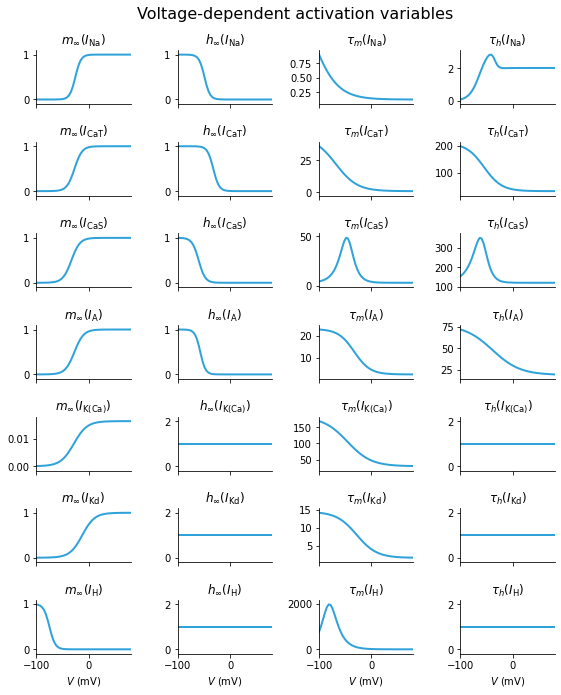

In [26]:
hv.output(backend="matplotlib")
activations_fig = act_curves.layout().cols(len(act_varnames))
activations_fig.opts(
    hv.opts.NdLayout(title="Voltage-dependent activation variables"),
    hv.opts.Curve(title="{label}({group})", xaxis="bare", ylabel=""),
    hv.opts.NdLayout(fig_inches=2, backend="matplotlib"),
    hv.opts.Curve(fig_inches=2, aspect=1.75, backend="matplotlib")
)
activations_fig["IH"].opts(hv.opts.Curve(xaxis="bottom"))
activations_fig

(sec_elec-synapse-model)=
## Electrical synapse model

The *AB* and *PD* neurons are connected via an electric synapse {cite:p}`prinzSimilarNetworkActivity2004`, which is given as Eq. (13) in {cite:t}`marderModelingSmallNetworks1998`:[^also-diff-sign]

$$I_e = g_e (V_{\mathrm{post}} - V_{\mathrm{pre}}) \,.$$ (eq-prinz-model-elec-synapse)

Unfortunately {cite:t}`prinzSimilarNetworkActivity2004` do not seem to document the value of $g_e$ they use. For our simulations we set it to 1, so it can be omitted in the implementation. $I_e$ is then simply implemented as `V[:,newaxis] - V`, which yields the following antisymmetric matrix

[^also-diff-sign]: As for the [chemical synapses](sec_chem-synapse-model), we invert the sign to match the convention in {cite:t}`prinzSimilarNetworkActivity2004`.

In [27]:
_ = ["AB", "PD1", "PD2"]
_ = np.array([["0" if post==pre else f"{post} - {pre}" for pre in _] for post in _])
_ = pd.DataFrame(_, index=pd.Index(["AB", "PD1", "PD2"], name="post ↓"), columns=pd.Index(["AB", "PD1", "PD2"], name="pre →")).style.set_caption("$V_{\mathrm{post}} - V_{\mathrm{pre}}$ matrix")
display_dataframe_with_math(_)

pre →,AB,PD1,PD2
post ↓,,,
AB,0,AB - PD1,AB - PD2
PD1,PD1 - AB,0,PD1 - PD2
PD2,PD2 - AB,PD2 - PD1,0


(sec_chem-synapse-model)=
## Chemical synapse model

The chemical synapse model is defined in {cite:t}`prinzSimilarNetworkActivity2004` (p.1351, §**Methods**) and {cite:t}`marderModelingSmallNetworks1998` (Eqs. (14,18,19)) Here again, in case of discrepancy, we use the notation from {cite:t}`prinzSimilarNetworkActivity2004`.[^diff-sign]

[^diff-sign]:  In particular that the two references use different conventions for the sign of $I_s$, which affects the sign in Eq. {eq}`eq-prinz-model-conductance`.

$$\begin{align*}
I_s &= g_s s (\Vpost - E_s) \\
\frac{ds}{dt} &= \frac{\sinf\bigl(\Vpre\bigr) - s}{τ_s} \\
\sinf\bigl(\Vpre\bigr) &= \frac{1}{1 + \exp\bigl((\Vth - \Vpre)/Δ\bigr)} \\
τ_s &= \frac{1 - \sinf\bigl(\Vpre\bigr)}{\km}
\end{align*}$$

:::{admonition} Note on numerical stability
:class: note dropdown

These are the equations as reported in {cite:t}`prinzSimilarNetworkActivity2004`, but as-is they are numerically unstable because $s$ should stay bounded between 0 and 1. The equations ensure this by assuming infinitely precise integration: as $s_\infty$ approaches 1, $τ_s$ goes to zero and $ds/dt$ diverges. Diverging derivatives cause a numerical integrator to stall, since it must make smaller and smaller time steps in order to maintain precision.

In the [implementation](sec-prinz-model-implementation) below, we mitigate this issues in two ways:

1. We actually track $\tilde{s} = \log \frac{s}{1-s}$, which is the logit transform of $s$. This has the advantage of being unbounded, so applying a discrete update $\tilde{s}_{t+Δt} = \tilde{s}_t + \frac{d\tilde{s}}{dt} Δt$ will never produce an invalid value of $\tilde{s}$. The logit function is also monotone and thus invertible; its inverse is $s = \frac{1}{1 + e^{-\tilde{s}}}$, and its derivative $\frac{d\tilde{s}}{dt} = \frac{1}{s(1-s)} \frac{ds}{dt}$.
2. We add a small $ε = 10^{-8}$ to the denominator to ensure it is never exactly zero:
   \begin{equation*}\frac{d\tilde{s}}{dt} = \frac{\sinf\bigl(\Vpre\bigr) - s}{τ_s \,s (1 - s) + ε} \,.\end{equation*}
:::

:::{admonition} Memory layout of synapse variables
:class: note dropdown

We have two types of synapses, *glutamatergic* and *cholinergic*, and an undetermined number of neurons. To take advantage of vectorized operations, we group synapse variables according to synapse type: since parameters are then constant within each group, we can treat them as scalars, and broadcasting works with any size of voltage vector $V$.

The $s$ dynamics depend only on the presynaptic neuron, so they only need to be computed once per neuron and can be tracked with a 1-d vector:

```{list-table} 1d memory layout for $s$, $s_{\infty}$ and $τ_\infty$
* - $s^{\mathrm{chol}}_{1}$
  - $\dots$
  - $s^{\mathrm{chol}}_{N_c}$
  - $s^{\mathrm{glut}}_{1}$
  - $\dots$
  - $s^{\mathrm{glut}}_{N_g}$ 
```

Here $N_c$ and $N_g$ are the numbers of cholinergic and glutamatergic neurons respectively. The synaptic currents take a 2-d structure, with *row* and *column* respectively corresponding to *post*synatic and *pre*synaptic neurons:

```{list-table} 2d memory layout for $I_s$
* - $I^\mathrm{chol}_{s,1 \leftarrow 1}$
  - $\dots$
  - $I^\mathrm{chol}_{s,1 \leftarrow N_c}$
  - $I^\mathrm{glut}_{s,1 \leftarrow N_c+1}$
  - $\dots$
  - $I^\mathrm{glut}_{s,1 \leftarrow N_c+N_g}$
* - $\vdots$
  - 
  - $\vdots$
  -
  -
  -
* - $I^\mathrm{chol}_{s,N_c \leftarrow 1}$
  - $\dots$
  - $I^\mathrm{chol}_{s,N_c \leftarrow N_c}$
  - $I^\mathrm{glut}_{s,N_c \leftarrow N_c+1}$
  - $\dots$
  - $I^\mathrm{glut}_{s,N_c \leftarrow N_c+N_g}$
* - $I^\mathrm{chol}_{s,N_c+1 \leftarrow 1}$
  - $\dots$
  - $I^\mathrm{chol}_{s,N_c+1 \leftarrow N_c}$
  - $I^\mathrm{glut}_{s,N_c+1 \leftarrow N_c+1}$
  - $\dots$
  - $I^\mathrm{glut}_{s,N_c+1 \leftarrow N_c+N_g}$
* - $\vdots$
  - 
  - $\vdots$
  -
  -
  -
* - $I^\mathrm{chol}_{s,N_c+N_g \leftarrow 1}$
  - $\dots$
  - $I^\mathrm{chol}_{s,N_c+N_g \leftarrow N_c}$
  - $I^\mathrm{glut}_{s,N_c+N_g \leftarrow N_c+1}$
  - $\dots$
  - $I^\mathrm{glut}_{s,N_c+N_g \leftarrow N_c+N_g}$
```

Note that the implementation requires two different splittings of the set of neurons:

- By population:
  + *AB/PD*
  + *LP*
  + *PY*
- By synapse type:
  + cholinergic (*PD*)
  + glutamatergic (*AB/LP/PY*)

By choosing to place *PD* neurons first, we ensure that the synapse subsets are contiguous, which improves computational efficiency.

:::

The conductivity $g_s$ determines the synapse’s strength, and therefore the network’s connectivity. See [Circuit model](sec-prinz-circuit-model) below.

The synapse parameters are chosen to match the inhibitory postsynaptic potentials (IPSPs) generated in the postsynaptic cell, which in turn depend on the type of neurotransmitter released by the *pre*synaptic cell.
For the purposes of the implementation, this means that these values depend on the type of *pre*synaptic cell.

:::{list-table}
:header-rows: 1
:stub-columns: 1

* - Cell type
  - Neurotransmitter
  - $E_s (\mathrm{mV})$
  - $\km (\mathrm{ms}^{-1})$
  - $\Vth (\mathrm{mV})$
  - $Δ (\mathrm{mV})$
* - pre $\in$ {*AB*, *LP*, *PY*}
  - glutamate
  - -70
  - 1/40
  - -35
  - 5
* - pre = *PD*
  - acetylcholine
  - -80
  - 1/100
  - -35
  - 5
:::

In general, if we have $N$ neurons, we would need to track a matrix of $N \times N$ synapse. 
However here the dynamics of $s$ depends only on $V_{\mathrm{pre}}$, and therefore it suffices to track $s$ as a vector of length $N$.

In [28]:
syn_constants = pd.DataFrame.from_dict(
    columns =       ["Es", "km" , "Vth", "Δ"],
    data = {"glut": [ 70 , 1/40 ,  -35 ,  5 ],
            "chol": [ 80 , 1/100,  -35 ,  5 ] },
    orient = "index",
    dtype = float
)

In [29]:
syn_constants

,Es,km,Vth,Δ
glut,70.0,0.025,-35.0,5.0
chol,80.0,0.010,-35.0,5.0


(sec-prinz-circuit-model)=
## Circuit model

The circuit used in {cite:t}`prinzSimilarNetworkActivity2004` is composed of three neuron populations:

:::{list-table} Neuron populations of the pyloric network
:header-rows: 1

* - Population name
  - Cell names
  - Number of cells
* - AB/PD  
    "pacemaker kernel"
  - anterior bursting  
    pyloric dilator
  - AB: 1  
    PD: 2
* - LP
  - lateral pyloric
  - 1
* - PY
  - pyloric
  - 5–8
:::

In {cite:t}`prinzSimilarNetworkActivity2004` the AB and PD are lumped together into a single model, with the only difference being that the AB cell has glutamatergic synapses while the PD cells have slower cholinergic synapses.

:::{figure} ./prinz-model_circuit-diagram_fig-1b-from-Prinz-2004_grey.svg
:width: 150px

Circuit diagram of the pyloric network, reproduced from Fig. 1 of {cite:t}`prinzSimilarNetworkActivity2004`.
:::

Network connectivity is determined by the synapse strength $g_s$. In {cite:t}`prinzSimilarNetworkActivity2004`, this parameter takes one of the following values:

:::{list-table} Possible synapse values ($g_s$)
:name: tbl_prinz-params_synapse-values

* - 0 nS
  - 1 nS  
    (PY only)
  - 3 nS
  - 10 nS
  - 30 nS
  - 100 nS
:::

(sec-prinz-model-implementation)=
## Implementation of $dV/dt$

The evolution equations are implemented as a function `dX` for use with SciPy’s ODE solvers. Since these integrate only a single vector argument, we concatenate $V$, $\bigl[\Ca^{2+}\bigr]$, $s$, $m$ and $h$ into a single array variable $X$.

Solving ODE requires a lot of function calls, and in this case the overhead of Python function calls does start to bite. To mitigate this, we pass all global constants and result arrays as arguments:
- Passing global constants reduces the time required to look up those values, since the local scope is searched before the global scope.
  Binding functions like `np.concatenate` to `concat` similarly saves the lookup of `np` in the global namespace, and the subsequent lookup of `concatenate` in the `np` namespace.
- Passing result arrays avoids the need to call `np.array`, which relative to other operations can have high overhead since it needs to allocate a new contiguous block of memory, as well as inspect the arguments for correctness. In practice this means things like the following:
  + Instead of `concat((E[:i], ECa, E[i+2:]))`, we do `E[i:i+2] = ECa`. This saves both the cost of allocating a new array, and the overhead of all other checks `concat` performs.

The `dX` implementation is written such that as many operations as possible are performed outside the function (memory allocation, model value retrieval, etc.). The best way to use it is through the public API below, which combines all these setup operations and takes care of passing all those arguments defined for optimization purposes. It also provides packing/unpacking of the `X` vector.


::::{admonition} Memory layout of $X$
:class: dropdown

The $X$ vector is in fact a flattened 2d array, where each column represents a different neuron. (Some of the $h$ variables are in fact always zero, but for simplicity and to allow better vectorization, we include them in $X$.)
 
Any code which receives $X$ in vector form can reconstruct the 2d array with `X.reshape(-1,N)`. Reshaping is an extremely cheap operation since it doesn’t require moving any data, and accessing either rows or columns is fast thanks to NumPy’s efficient indexing.

:::{list-table}

* - $V_1$
  - $\dots$
  - $V_N$
* - $\bigl[\Ca^{2+}\bigr]_1$
  - $\dots$
  - $\bigl[\Ca^{2+}\bigr]_N$
* - $s_1$
  - $\dots$
  - $s_N$
* - $m_{\Na,1}$
  - $\dots$
  - $m_{\Na,N}$
* - $\vdots$
  -
  - $\vdots$
* - $m_{\leak,1}$
  - $\dots$
  - $m_{\leak,N}$
* - $h_{\Na,1}$
  - $\dots$
  - $h_{\Na,N}$
* - $\vdots$
  -
  - $\vdots$
* - $h_{\leak,1}$
  - $\dots$
  - $h_{\leak,N}$
:::
::::

:::{admonition} Possibilities for future optimization
:class: dropdown

If you like the code below, but it isn’t quite fast enough for your needs, here are some possibilities.

Vectorize along time axis
~ As it is, `dX` expects `t` to be a scalar and `X` to be a 1-d array. If it were reworked to
  accept an additional batch dimension (so `t` of shape `(T,)` and `X` of shape `(T,n)`), then
  we could pass the `vectorized=True` option to `solve_ivp`, allowing it to compute multiple time
  points at once and reducing function call overhead.
  The main challenge here is that `act_fn` currently only accepts arbitrary numbers of dimensions
  on the right, but the left-most one must be channels. This is partly for efficiency considerations.
  One would either need to adapt `act_fn`, or reorder the data to put the channel dimension before
  time.
  A second, smaller challenge is finding an efficient way to update the `E` array when the size
  of the time dimension is unknown in advance.

Optimize the linear algebra operations
~ For simplicity, when evaluating currents, the implementation uses expressions of the form
  $$\sum_j [g u v^T]_{ij} \,$$
  where $g$ is a matrix and $u$ and $v$ are vectors. This produces the $N \times N$ matrix $u v^T$ as an intermediate step.
  Reworking the expression to use `.dot` would like provide some improvements, although as long as the number of neurons is small, this improvement may be modest.
  
Rewrite using JAX
~ If one really needs C-level performance, the most effective approach (in terms of gain/effort) may be be to rewrite this function with [JAX](https://jax.readthedocs.io).
  This should be much simpler than porting to C, since the API of JAX is by design nearly identical to that of NumPy.
  Moreover, by keeping the code in terms of high-level linear algebra operations, we leave the optimization to JAX, which is likely to do a better job than any custom C-code we write.
  In particular, since all of the costly operations are standard linear algebra, one could use JAX’s ability to compile for GPU, and possibly obtain a simulator capable of simulating very large numbers of neurons on a single workstation.
    
Rewrite as a C function
~ SciPy has an object called a `LowLevelCallable`, which can be used to pass callback functions to SciPy functions which don’t carry the overhead of a Python function.
  This is useful for things like integrators, where the number of calls is large compared to the evaluation time of a single function call.
  However doing this is a lot of work, and we lose the possibility to use NumPy’s array broadcasting to keep code at a relatively high level.
  Rewriting in JAX is likely to be much faster, and might allow use of additional resources like GPUs.

:::

:::{margin}
For technical reasons, we want arguments to `dX` to be hashable. This allows us to use accelerator utilities which rely on hashing arguments (like JaX’s JIT).

This means that instead of providing slices directly as arguments, we need to provide their reduce value, obtained with `.__reduce__()` (for some discussion, see this [SO question](https://stackoverflow.com/q/29980786) and the references therein). The reduce value is of the form `(slice, (<start>, <stop>, <step>)`. The first step in `dX` is therefore to reconstitute the slices by calling `slice` on the second argument of the reduce value.

(`jax.jit` is a little more flexible than the other utilities, in that it only needs *static* arguments to be hashable. Other utilities may require that also arrays be passed in hashable form.)
:::

In [30]:
Index = Union[int,None]
SliceReduceVal = Tuple[Type[slice], tuple[Index,Index,Index]]

In [31]:
@partial(jax.jit,
         static_argnames=["pop_slices", "syn_slices", "elec_slice",
                          "nchannels", "n_neurons", "I_ext",
                          #"γ", "Caout", "Eleak", "p",
                          #"f", "Ca0", "τCa",
                          "idx_ICaT", "idx_ICaS",
                          #"Es_tuple", "km_chol", "km_glut", "Vth_chol", "Vth_glut", "Δ_chol", "Δ_glut", "ε",
                         ]
        )
def dX(t, X,
       ## Extra parameters which should be passed with the `args` argument of the ODE solver ##
       g,   # Shape: n_pops x n_channels  (3 x 7)  <-- DOES NOT INCLUDE LEAK
       gleak,
       gs,  # Shape: n_pops x n_pops  (3 x 3)
       ge,  # Electrical conductance is generally fixed to 1, except when we need to remove all connections to compute spontaneous activity
       pop_slices: Tuple[SliceReduceVal],  # Slices for each of the three neuron populations AB/PD, LP and PY, in that order
       syn_slices: Tuple[SliceReduceVal],  # Slices for selecting neurons according to their synapse type: cholinergic (PD) and glutamatergic (AB, LP, PY), in that order
                                  # NOTE: We exploit the fact that types & populations can be ordered so that all subsets are contiguous blocks.
                                  #       This improves efficiency but is not essential: for non-contiguous blocks, we could use arrays to specify an advanced index
       elec_slice: SliceReduceVal, # Slice for selecting the neurons which have electrical synapses (i.e. AB/PD)
       E,   # constants.E.reshape(..., n_neurons)
       #Ii,  # empty(n_channels, n_neurons)
       #Is,  # empty(n_neurons)
       n_neurons,   # Used for unpacking X
       I_ext = None,
       *,
       ## Below are constants, pulled from the global module variables. They should not be used as arguments ##    
       # X unpacking
       nchannels  = len(channels),    # Number of non-leak ion channels (7)
       nhchannels = nhchannels,       # Number of channels with an h variable (4)
       h_slice     = h_slice,
       # E_Ca - Eq (3)
       γ     = constants.γ,
       logCaout = jnp.log(constants.Caout),
       # dI - Eq (1)
       Eleak = constants.Eleak,
       p     = constants.p[...,np.newaxis],
       # dCa - Eq (2)
       f        = constants.f,
       Ca0      = constants.Ca0,
       τCa      = constants.τCa,
       idx_ICaT = channels.index("ICaT"),
       idx_ICaS = channels.index("ICaS"),
       # Ie - Eq (5)
       # Is - Eq (6)
       Es_tuple = tuple(syn_constants.loc[["chol", "glut", "glut", "glut"], "Es"]),  # FIXME: Hard-coded pops.  Follows order in syn_slices
       km_chol  = syn_constants.loc["chol", "km" ],
       km_glut  = syn_constants.loc["glut", "km" ],
       Vth_chol = syn_constants.loc["chol", "Vth"],
       Vth_glut = syn_constants.loc["glut", "Vth"],
       Δ_chol   = syn_constants.loc["chol", "Δ"  ],
       Δ_glut   = syn_constants.loc["glut", "Δ"  ],
       ε        = 1e-8,   # Added to a denominator that may be zero
       # functions
       clip       = jnp.clip,
       concat     = jnp.concatenate,
       empty_like = jnp.empty_like,
       exp        = jnp.exp,
       log        = jnp.log,
       minimum    = jnp.minimum,
       newax      = jnp.newaxis,
       swapaxes   = jnp.swapaxes,
       tile       = jnp.tile
      ):
    # Shape convention: parameter x voltage
    #     (equivalent): (channel) x (neuron)
    
    # Reconstitute slices
    pop_slices = tuple(T(*args) for T, args in pop_slices)
    syn_slices = tuple(T(*args) for T, args in syn_slices)
    elec_slice = elec_slice[0](*elec_slice[1])
    
    # Unpack the vector argument
    X = X.reshape(3+nchannels+nhchannels, n_neurons)
    V, logCa, logits, logitm, logith, = (
        X[0], X[1], X[2],
        X[3:3+nchannels], X[3+nchannels:3+nchannels+nhchannels],
    )
    Ca = exp(logCa)
    s = 1 / (1 + exp(-logits))  # Inverse of the logit function  (NB: expression remains well defined even when exp(logits) -> oo)
    m = 1 / (1 + exp(-logitm))
    h = 1 / (1 + exp(-logith))
    
    
    # Update reversal potentials using Eq. (3)
    #E = tile(E, (len(X),1))  # I’m not happy with the copy, but I don’t see a better way to support modifying ECa when the size of the first dimension (time) is unknown
    # JAXMOD E[...,[1,2],:] = γ*Caout/Ca  # Modifying E in-place is fine as long as no other function does so
    E = E.at[...,[idx_ICaT,idx_ICaS],:].set( γ * (logCaout - logCa) )
    
    # Compute conductance inputs                  # g.shape    :  pop x channel
                                                  # pop_g.shape: channel
    #mphVE  = m**p * h * (V-E)                    # shape: channel x neuron
    mphVE  = m**p * (V-E)                         # shape: channel x neuron
    mphVE  = mphVE.at[h_slice,:].multiply(h)
    Ii = concat(
        [pop_g[:,newax] * mphVE[...,slc]          # shape: channel x pop_size
         for pop_g, slc in zip(g, pop_slices)],
        axis=-1
    )
    # for pop_g, slc in zip(g, pop_slices):
    #     Ii[:,slc] = pop_g[:,newax] * mphVE[:,slc] # shape: channel x pop_size
    # Ii has shape: channel x neuron
    
    # Compute dCa using Eq. (2)
    dCa = (-f * (Ii[...,idx_ICaT,:] + Ii[...,idx_ICaS,:]) - Ca + Ca0) / τCa
    dlogCa = dCa / Ca   # Chain rule w/ log transform
    
    # Compute the voltage-dependent activation variables using definitions in §Voltage-dependent activation variables
    m_inf, h_inf, τ_m, τ_h = act_vars(V, Ca)
    h_inf = h_inf[h_slice]  # For vectorization reasons, act_vars (at least for now)
    τ_h   = τ_h[h_slice]    # returns dummy values for channels with no h var
    
    # Compute dm and dh using Eq (1)
    dm = (m_inf - m) / τ_m
    dh = (h_inf - h) / τ_h
    dlogitm = dm / (m * (1-m))  # Chain rule through logit
    dlogith = dh / (h * (1-h))  # Chain rule through logit
    
    # Compute electrical synapse inputs using Eq (5)
    Ve = V[...,elec_slice,newax]
    Ie = ge * (Ve - swapaxes(Ve,-1,-2)).sum(axis=-1)   # This computes Ve - Ve.T, allowing for an additional time dimension on the left
        # ge is assumed to be a scalar. Currently we always set it to 1, or 0 if we are computing the thermalization (which requires a completely disconnected network)
    
    # Compute the synaptic inputs using Eq (6)
    # (By splitting glut & chol, we can use scalars for all parameters and not have to worry about broadcasting with the shape of V)
    cholslc, glutslc = syn_slices
    
    Vglut = V[...,glutslc]
    Vchol = V[...,cholslc]
    s_glut = s[...,glutslc]
    s_chol = s[...,cholslc]
    
    sinf_glut = 1 / (1 + exp(Vth_glut - Vglut)/Δ_glut)  # shape: (n_glut,)
    sinf_chol = 1 / (1 + exp(Vth_chol - Vchol)/Δ_chol)  # shape: (n_chol,)
    τs_glut = (1 - sinf_glut) / km_glut                 # shape: (n_glut,)
    τs_chol = (1 - sinf_chol) / km_chol                 # shape: (n_chol,)
    # ds_glut = (sinf_glut - s_glut) / τs_glut            # shape: (n_glut,)
    # ds_chol = (sinf_chol - s_chol) / τs_chol            # shape: (n_glut,)
    dlogits_glut = (sinf_glut - s_glut) / (τs_glut * s_glut * (1-s_glut) + ε)   # Incl. chain rule w/ logit transform.
    dlogits_chol = (sinf_chol - s_chol) / (τs_chol * s_chol * (1-s_chol) + ε)   # ε=1e-8 is added for numerical stability
    
    dlogits = empty_like(logits)
    dlogits = dlogits.at[cholslc].set(dlogits_chol)
    dlogits = dlogits.at[glutslc].set(dlogits_glut)

    # Sum synaptic inputs from each population
    Is = concat(
        [sum((gs[i,j] * s[preslc] * (V[postslc,np.newaxis] - Es_tuple[j])).sum(axis=-1)
             for j, preslc in enumerate(pop_slices))
         for i, postslc in enumerate(pop_slices)],
        axis=-1
    )
    # jax.debug.print("Is: {}", Is)
    # jax.debug.print("dlogits: {}", dlogits)
    # # Alternative 1: In-place updates of a pre-allocated array
    # Is[:] = 0
    # for i, postslc in enumerate(pop_slices):
    #     for j, preslc in enumerate(pop_slices):
    #         Is[postslc] += (gs[i,j] * s[preslc] * (V[postslc,np.newaxis] - Es_tuple[j])).sum(axis=-1)
    # # Alternative 2: Construct a block matrix. The extra allocation of
    # # memory makes this slower, but can be useful for diagnosis
    # blocks = [[gs[i,j] * s_tuple[j] * (V[postslc,np.newaxis] - Es_tuple[j])
    #            for j, preslc in enumerate(pop_slices)]
    #           for i, postslc in enumerate(pop_slices)]
    # Is = np.block(blocks).sum(axis=-1)

    
    # # Asserts serve as documentation, and can be uncommented to re-validate code after changes.
    # _A = np.arange(50)
    # assert Ii.shape == (nchannels, len(V)), "Conductance input matrix doesn’t have the right shape."
    # assert np.array(Is_chol.shape) + np.array(Is_glut.shape) == (len(V),), "Synaptic input matrix doesn’t have the right shape."
    # assert np.all(concat([_A[slc] for slc in pop_slices]) == _A[:len(V)]), "Pop slices are not contiguous or don’t add up to the total number of neurons."
    # assert np.all(concat([_A[slc] for slc in syn_slices]) == _A[:len(V)]), "Synapse type slices are not contiguous or don’t add up to the total number of neurons."
    # assert ds_chol.shape == (2,)
    
    # Compute dV by summing inputs over channels
    dV = -Ii.sum(axis=-2) - Is
    # Add external inputs
    if I_ext:
        dV -= I_ext(t)
    # Add contributions currents from electrical synapses
    #dV[..., elec_slice] -= Ie
    dV = dV.at[..., elec_slice].add(-Ie)   # JAXMOD
    # Add leak currents
    for pop_gleak, slc in zip(gleak, pop_slices):
        #dV[...,slc] -= pop_gleak * (V[...,slc] - Eleak)
        dV = dV.at[...,slc].add(- pop_gleak * (V[...,slc] - Eleak) )  # JAXMOD

    # Combine all derivatives and return
    return concat((dV.reshape(1,-1), dlogCa.reshape(1,-1), dlogits.reshape(1,-1), dlogitm, dlogith)).reshape(-1)

(sec-initialization)=
## Initialization

For the experiments, we want to initialize models in a steady state. To find this steady state, we first need to run the model, generally for much longer than the amount of simulation time we need for the experiment itself. We definitely don’t want to do this every time, so after simulating a model, we store the initial state in a cache on the disk. Thus we distinguish between two types of initialization:

Cold initialization
~ This is a fixed initial state used for all models, when no previous simulations are available. It is used for the thermalization run, which
  integrates the model until it reaches a steady state.

Thermalized (“warm”) initialization
~ The final state of the initialization run is the thermalized initialization. 
  Subsequent calls with the same model will retrieve this state from the cache.
  
During the thermalizaton run, the model is disconnected (all connectivities $g_s$ are set to 0) and receives no external input;
this mirrors the procedure followed by {cite:t}`prinzAlternativeHandTuningConductanceBased2003`.
If we did not disconnect neurons, many of them would never reach a steady state since the circuit is designed to spontaneously oscillate.
Moreover, one would need to generate and store a different initialization for each circuit, rather than for each neuron, which is combinatorially many more.

Cold initialization values are provided by on p. 4001 of {cite:t}`prinzAlternativeHandTuningConductanceBased2003`:[^cold-init-s]

:::{list-table} Cold initialization
* - $V$
  - $\bigl[\Ca^{2+}\bigr]$
  - $m$
  - $h$
  - $s$
* - $-50\, \mathrm{mV}$
  - $0.05\, \mathrm{μM}$
  - 0
  - 1
  - 0
:::

There are five main technical differences between our procedure and that of {cite:t}`prinzSimilarNetworkActivity2004`:

- For numerical stability, we track the values of $\logit m$, $\logit h$ and $\logit s$. This means we can’t initialize them exactly at 0 or 1; instead we use $\logit m = \logit s = -10$ and $\logit h = 10$, which correspond to approximately $m = s = 10^{-5}$ and $h = 10^5$.

- {cite:t}`prinzSimilarNetworkActivity2004` set $s=0$ after the thermalization. This is presumably because the original neuron model catalog did not include simulations of $s$. In our case, we set $s=0$ for the cold initialization, and use its subsequent thermalized value for the data run. This is both simpler on the implementation side, and more consistent with the desire to let all spontaneous transients relax before connecting neurons.

- We don’t first compute the thermalization for individual model neurons separately, but instead recompute it for each combination of neuron models. (Specifically, each thermalization run is identified by a `g_cond` matrix – $g_s$ and $I_{\mathrm{ext}}$ are ignored, since they are set to zero during thermalization.) If we were to simulate the entire catalog of neuron model combinations this would be wasteful, but since we only need a handful, this approach is adequate and simpler to implement.

- Instead of fixed-step Euler integration, we use the Runge-Kutta 4(5) algorithm with adaptive step sizes included in `scipy.integrate`. This is not only more efficient than Euler, but also allows one to estimate numerical errors.
  (Although the integration scheme is currently hard-coded, since we are using standard `scipy` integrators, it would be easy enough to change it or make it user-configurable. Indeed, while standard, RK45 is not necessarily the best choice for Hodgkin-Huxley systems since they are moderately stiff.)

- Finally, instead of detecting the steady state automatically, we use a fixed integration time and rely on visual inspection to determine whether this is enough to let transients decay in all considered models. Again we can do this because we only need to simulate a handful of models.

[^cold-init-s]: Except for $s$, which is initialized to 0 based on the section *Network simulation and classification* of {cite:t}`prinzSimilarNetworkActivity2004`. In any case, since we set the value of $g_s$ to 0 during the initialization run, the initial value we choose for $s$ is not important.

The main *practical* difference is that instead of pre-computing a neuron catalogue, the thermalization is done automatically and on-demand. For the user therefore it makes no difference whether a warm initialization for a particular circuit is available or not: when they request a simulation, if no warm initialization is available, they just need to wait longer to get their result. Subsequent runs then reuse the warm initialization computed on the first run.

**Implementation**
- The cold initialization is given by the class method `State.cold_initialized`.
- The warm-up simulation is implemented in the method `Prinz2004.get_thermalization`.

Three class attributes of [`Prinz2004`](prinz2004-object) are used to control the behaviour of the warm-up simulation:

- `__thermalization_store__` determines where the cache is stored on disk.
- `__thermalization_time__` is the warm-up simulation time; it is currently set to 5s.
- `__thermalization_time_step__` is the recording time step for the warm-up simulation. This is only relevant for inspecting the warm-up run. (The integrator uses an adaptive time step and discards non-recorded steps.)

## Public API

### `State` object

In order to integrate the model equations, we need to know not just the membrane potential of each neuron, but also its calcium concentration, synaptic variable ($s$) and activation and inactivation variables ($m$, $h$). These are stored together in a `State` object, which also provides
- automatic conversion to/from log-transformed values;
- convenience methods for converting between different storage layouts, for example concatening and flattening all variables for the ODE integrator.

In [32]:
@dataclass
class State:
    V     : Array[float, 1]  # (n_neurons)
    logCa : Array[float, 1]  # (n_neurons)
    logits: Array[float, 1]  # (n_neurons)
    logitm: Array[float, 2]  # (n_neurons, n_channels)
    logith: Array[float, 2]  # (n_neurons, n_channels)

    """Storage container for simulator variables.

    - Handles automatic conversion to/from log-transformed values.
    - Provides methods for converting between storage layouts, in particular for
    exporting to the 1-d vector format required by ODE integrators.
    """

    @classmethod
    def cold_initialized(cls, n_neurons):
        """Default state initialization. Used to initialize the thermalization run."""
        return cls(
            -50   * jnp.ones(n_neurons),
            jnp.log(0.05) * jnp.ones(n_neurons),
            -10 * jnp.ones(n_neurons),   # “fully deactivated” would be s=0, which is not possible with the logit, but this should be close enough
            -10 * jnp.ones((n_neurons, len(channels))),  # “fully deactivated”
            10 * jnp.ones((n_neurons, nhchannels)),   # “fully activated”
        )   

    @classmethod
    def from_array(cls, X: Union[Array[float, 1], Array[float, 2]]) -> "Prinz2004.State":
        """Unpack a flattened state vector."""
        nchannels = len(channels)
        if X.ndim == 1:
            X = X.reshape(3+nchannels+nhchannels, -1)
        elif X.ndim != 2:
            raise ValueError(f"State array `X` has {X.ndim} dimensions, when it should have either 1 or 2.")
        return cls(
            jnp.array(X[0]), jnp.array(X[1]), jnp.array(X[2]),
            jnp.array(X[3:3+nchannels]), jnp.array(X[3+nchannels:3+nchannels+nhchannels]),
        )
    def to_vector(self):
        """Return a flat 1-d vector, as is used in `solve_ivp`."""
        return jnp.concatenate((self.V, self.logCa, self.logits, self.logitm.flatten(), self.logith.flatten()))
    def to_array(self):
        """
        Return a 2-d array of shape (3+2*n_channels, n_neurons)
        First three rows are `V`, `logCa`, `logits` respectively.
        Then `m` and `h` as two blocks of (n_channels, n_neurons).
        """
        return jnp.concatenate((
            self.V[np.newaxis,:], self.logCa[np.newaxis,:], self.logits[np.newaxis,:],
            self.logitm, self.logith))

    @property
    def s(self):
        return 1 / (1 + 1/np.exp(self.logits))  # Inverse of the logit function  (NB: expression chosen to be well defined even when exp(logits) -> oo)
    @s.setter
    def _(self, s):
        self.logits = np.log(s/(1-s))
    @property
    def m(self):
        return 1 / (1 + 1/np.exp(self.logitm))
    @m.setter
    def _(self, m):
        self.logitm = np.log(m/(1-m))
    @property
    def h(self):
        return 1 / (1 + 1/np.exp(self.logith))
    @h.setter
    def _(self, h):
        self.logith = np.log(h/(1-h))
    @property
    def Ca(self):
        return np.exp(self.logCa)
    @Ca.setter
    def _(self, Ca):
        self.logCa = np.exp(Ca)

(simresult-object)=
### `SimResult` object

The ODE integrators provided by `scipy.integrate` treat the data as a flat 1-D vector, which is not convenient for associating the trace of each component to the correct state variable.
A `SimResult` stores the data returned from the integrator, in the integrator’s compact format, but provides a human-friendly interface for retrieving traces for individual variables. Conversions to/from log-transformed values are handled automatically.

In [33]:
@dataclass
class SimResult:
    t         : Array[float, 1]
    data      : Array[float, 3]
    pop_slices: List[slice]
    
    """Stores and makes accessible the results of a simulation run.

    Underlying storage is very close to the output of the ODE simulator.
    Properties for each variable (`V`, `logCa`, `Ca`, etc.) retrieve the correct rows from the data structure.
    """

    def __post_init__(self):
        self.data = self.data.reshape(3+len(channels)+nhchannels, -1, len(self.t))
        self.data = np.moveaxis(self.data, -1, 0)  # Both Pandas & Holoviews work better if time is the index axis
    
    def __getitem__(self, key) -> Union[SimResult,State]:
        if isinstance(key, (slice, list, np.ndarray)):
            return SimResult(t=self.t[key], data=self.data[key,:,:], pop_slices=self.pop_slices)
        elif isinstance(key, int):
            return self.t, State.from_array(self.data[key,:,:])
        else:
            raise TypeError("SimResult` only supports 1-d indexing along the time axis.")
    
    @property
    def V(self): return self._make_df(self.data[:, 0, :])
    @property
    def logCa(self): return self._make_df(self.data[:, 1, :])
    @property
    def Ca(self): return np.exp(self.logCa)
    @property
    def logits(self): return self._make_df(self.data[:, 2, :])
    @property
    def s(self): return 1 / (1 + np.exp(-self.logits))
    @property
    def logitm(self): return self.data[:, 3:3+len(channels), :]
    @property
    def m(self): return 1 / (1 + np.exp(-self.logitm))
    @property
    def logith(self): return self.data[:, 3+len(channels):3+len(channels)+nhchannels, :]
    @property
    def h(self): return 1 / (1 + np.exp(-self.logith))

    def _make_df(self, data):
        cols = pd.MultiIndex.from_tuples(
            ((pop, i)
             for pop, slc in self.pop_slices.items()
             for i in range(1, 1+slc.stop-slc.start)),
            names=["pop", "index"]
        )
        return pd.DataFrame(data, index=pd.Index(self.t, name="time"), columns=cols)

(prinz2004-object)=
### `Prinz2004` object

This is the core simulator class. To perform a simulation, create an instance of this class and call its `integrate` method.

In [34]:
@dataclass(frozen=True)
class Prinz2004:
    pop_sizes  : dict[str, int]
    gs         : Array[float, 2]
    g_ion: Optional[Array[float, 2]]=None
    ge         : float=1.  # Currently only used to turn on/off electrical connectivity

    """ Core simulator class.

    To perform a simulation, create an instance of this class and call its `integrate` method.
    """
    
    # Private attributes
    __thermalization_store__ : ClassVar[Path] = config.paths.simresults/"prinz2004_thermalize"
    __thermalization_time__  : ClassVar[float] = 5000.   # Warm initialization is the state after this many seconds of spontaneous activity (no inputs, no synaptic connections)
    __thermalization_time_step__: ClassVar[float] = 1.   # Warm initialization trace is recorded with this time step
        # TODO: Instead of a fixed time step, using an `events` callback to detect spikes could substantially reduce the data we need to store
    _thermalization_store_lock: ClassVar[Lock] = Lock(str(__thermalization_store__.with_suffix(".lock")))
    _thermalization_store_lock.lifetime = timedelta(seconds=15)  # 15s is the default
        
    def __post_init__(self):
        # For convenience, we allow passing `g_ion` as a DataFrame
        if isinstance(self.g_ion, pd.DataFrame):
            object.__setattr__(self, "g_ion", self.g_ion.to_numpy())
        object.__setattr__(self, "gs", np.asarray(self.gs))

    ## Public API ##
    
    def __call__(self, t_array, I_ext: Optional[Callable]=None):
        X0 = self.get_thermalization()
        res = self.integrate(0, X0, t_array, I_ext)
        return SimResult(t_array, res.y, self.pop_slices)
    
    def derivative(self, t: float, X: State, I_ext: Optional[Callable]=None):
        """
        Evaluate the model equations, returning the derivative at `t` if the state is `X`.
        This is a convenience method; it is equivalent to the code used to integrate, but not the same.
        """
        X0 = X
        # C.f. self.integrate()
        if isinstance(X0, State):
            X0_flat = X0.to_vector()
        else:
            X0_flat = X0.flatten()
            X0 = self.State.from_vector(X0)
        pop_slices = tuple(slc.__reduce__() for slc in self.pop_slices.values())
        syn_slices = (self.syn_slices["chol"].__reduce__(), self.syn_slices["glut"].__reduce__())
        elec_slice = self.elec_slice.__reduce__()
        args=(self.g, self.gleak, self.gs, self.ge,  # Conductances
              pop_slices, syn_slices, elec_slice,    # Population slices
              self.E(X0.Ca),                         # Expanded from constants.E (except E[[1,2],:], corresponding to ECa, which is updated in-place)
              self.tot_cells,                        # Pre-computed number of neurons
              I_ext)                                 # External input, if provided
        return dX(t, X0_flat, *args)

    ## Semi-private methods ##
    
    # Even though the dataclass is frozen, changing the init_store is allowed (at worst, it just means the thermalization is recomputed)
    @classmethod
    def clear_thermalization_store(cls):
        cls.__thermalization_store__.unlink(missing_ok=True)
    
    def integrate(self, t0: float, X0: Union[Array, Prinz2004.State], t_eval: ArrayLike,
                  I_ext: Optional[Callable]=None) -> OdeResult:
        """
        Integrate the model from the initial state `(t0, X0)`. The result will contain the states
        at all values in `t_eval`.
        
        Args:
            t0: time corresponding to X0
            X0: Initial state; either an instance of Prinz2004 or a flat vector.
            t_eval: The time points at which to record the trace
            I_ext: If provided, this should be a function with the signature ``(t) -> I``, where ``I``
               is a 1-d vector with one element for every neuron. The units of I are nA; its value is
               added directly to the derivative dV.
               Alternatively, if all neurons should receive the same input, ``I`` can be a scalar.
               (In case we do support a vectorized `dX` later, if the function accepts a vector as input,
               the result should be of shape ``(time x neurons)``.
        """
        if isinstance(X0, State):
            X0_flat = X0.to_vector()
        else:
            X0_flat = X0.flatten()
            X0 = self.State.from_vector(X0)
        
        t_eval = np.sort(t_eval)
        T = t_eval[-1]
        
        # NB: Order is important for syn_slices
        pop_slices = tuple(slc.__reduce__() for slc in self.pop_slices.values())
        syn_slices = (self.syn_slices["chol"].__reduce__(), self.syn_slices["glut"].__reduce__())
        elec_slice = self.elec_slice.__reduce__()
        
        res = integrate.solve_ivp(
            dX, (t0, T), X0_flat, method="RK45", t_eval=t_eval,
            args=(self.g, self.gleak, self.gs, self.ge,  # Conductances
                  pop_slices, syn_slices, elec_slice,    # Population slices
                  self.E(X0.Ca),                         # Expanded from constants.E (except E[[1,2],:], corresponding to ECa, which is updated in-place)
                  self.tot_cells,                        # Pre-computed number of neurons
                  I_ext),                                # External input, if provided
            first_step=0.005)#constants.Δt)
        
        if res.status < 0:
            raise RuntimeError(f"Integration failed with the following message:\n{res.message}")
            #logger.error(res.message)
        return res
    
    @property
    def g_cond(self):
        if self.g_ion is not None:
            # Explicitely assigned g_cond
            return pd.DataFrame(self.g_ion,
                                index=self.pop_model_list, columns=g_cond.columns)
        else:
            return g_cond.loc[self.pop_model_list]
    @property
    def g(self):
        g_no_leak = self.g_cond.filter(regex=r"mathrm{(?!leak)")
        #_pop_lst = [self.pop_models["AB/PD"], pop_models["LP"], pop_models["PY"]]
        return g_no_leak.to_numpy()
    @property
    def gleak(self):
        return self.g_cond.loc[:, '$g(I_\\mathrm{leak})$'].to_numpy()
    
    def E(self, Ca):
        E = jnp.tile(constants.E[:,np.newaxis], (1, self.tot_cells))
        E = E.at[[1,2],:].set(constants.γ*np.log(constants.Caout/Ca))
        return E
    
    @property
    def tot_cells(self):
        return sum(self.pop_sizes.values())
    @property
    def pop_model_list(self):
        """
        Returns a list of the form ``["AB 3", "PD 3", "LP 2", "PY 4"]``, where values
        correspond to model labels used in `g_cond`. They may omit numbers, if those are
        also omitted in `g_cond`.
        """
        return list(self.pop_slices.keys())
        # # CODE FOR LATER: The following was originally used to merge AB and PD pop labels
        # # AB 1 or PD 1 -> AB/PD 1  (where '1' is any number)
        # slcs = self.create_slices(
        #     self.pop_sizes, label_sub={r"(?:AB|PD)( \d+)?": r"AB/PD\1"})
        # return list(slcs.keys())
    
    @property
    def pop_slices(self):
        # If pops are specified as AB/PD, split them AB: 1, PD: n-1
        pop_sizes = {}
        for name, size in self.pop_sizes.items():
            m = re.match(r"AB/PD( \d+)?", name)
            if m:
                pop_sizes[f"PD{m[1]}"] = size - 1
                pop_sizes[f"AB{m[1]}"] = 1
            else:
                pop_sizes[name] = size
        return self.create_slices(pop_sizes, {})
    
    @property
    def syn_slices(self):
        # If pops are specified as AB/PD, split them AB: 1, PD: n-1
        pop_sizes = {}
        for name, size in self.pop_sizes.items():
            m = re.match(r"AB/PD( \d+)?", name)
            if m:
                pop_sizes[f"PD{m[1]}"] = size - 1
                pop_sizes[f"AB{m[1]}"] = 1
            else:
                pop_sizes[name] = size
        # When creating the slices:
        # AB, LP, PY -> glut    PD -> chol
        slices = self.create_slices(
            pop_sizes, label_sub={r"(?:AB|LP|PY)( \d+)?": r"glut",
                                  r"(?:PD)( \d+)?": r"chol"})
        # Corner case: If there are no cholinergic or glutamatergic neurons,
        #    add corresponding empty slices
        if "glut" not in slices: slices["glut"] = slice(0,0)
        if "chol" not in slices: slices["chol"] = slice(0,0)
        return slices
    @property
    def elec_slice(self):
        slcs = self.create_slices(
            self.pop_sizes, label_sub={r"(?:AB|PD).*": "elec"}, include=[r"AB|PD"])
        return slcs.get("elec", slice(0,0))  # If there are no neurons with electrical synapses, return an empty slice
  
    def get_thermalization(self) -> State:
        """
        The thermalization is obtained by integrating the network model
        with all connections to zero, to find the spontaneous steady-state of
        each neuron model.
        This method either performs that integration, or, if it was already
        done before, retrieves it from a cache.
        """
        sim = self.thermalize()
        t, X = sim[-1]  # Get the final state
        # Warm init is done with one neuron per population: reinflate the populations.
        # NB: The thermalization uses the merged AB/PD populations of pop_slices
        pop_sizes = tuple(slc.stop-slc.start for slc in self.pop_slices.values())
        return State.from_array(
            np.repeat(X.to_array(), pop_sizes, axis=-1)
        )
    
    def thermalize(self) -> SimResult:
        """
        Compute the initial simulation used to thermalize the model.
        - Constructs a surrogate model with all population sizes set to 1.
        - Sets all connectivities to 0.
        - Integrate
        
        In addition, this method manages the termalization cache, and will skip
        all steps if it finds a result already in the cache.
        
        .. TODO:: Currently the cache key is the entire model, which is a bit
           wasteful. It would be better to cache the results of each neuron
           separately.

        Returns a `SimResult` instance, with recording resolution determined by
        ``self.__thermalization_time_step__``.
        
        Normally this method is not used directly, but called by `get_thermalization`.
        The main reason to use it directly would be to plot the initialization
        run for inspection.
        """
        # # Pre-compute the set of pop_slices, so we can validate it against the disconnected model
        # # (Alternatively, we could create a disconnected model even when we find a pre-cached result, but that seems wasteful)
        # pop_slices = {}; i = 0
        # for pop in self.pop_slices:
        #     if pop.startswith("AB/PD"):
        #         pop_slices[pop] = slice(i,i+2); i += 2
        #     else:
        #         pop_slices[pop] = slice(i,i+1); i += 1
        # We thermalize the model by turning off synaptic connections,
        # so we also use a key which only depends on the model identities.
        init_key = str((("T", self.__thermalization_time__), ("g_cond", self.g_cond.to_csv())))
        if not self.__thermalization_store__.exists():
            self.__thermalization_store__.parent.mkdir(parents=True, exist_ok=True)
            warm_t_X = None
        else:
            with shelve.open(str(self.__thermalization_store__), 'r') as store:
                warm_t_X = store.get(init_key)
        if warm_t_X:
            t, warm_X = warm_t_X
        else:
            # NB: We use pop_slices instead of pop_sizes in order to merge AB/PD populations when possible
            # Get the cold initialized state (for a smaller model with 1 neuron / pop)
            X0 = State.cold_initialized(len(self.pop_slices))
            # Construct the array of times at which we will record
            init_T = self.__thermalization_time__
            Δt = self.__thermalization_time_step__
            t_eval = np.concatenate((np.arange(0, init_T, Δt), [init_T]))  # The final time init_T is always evaluated
            # Build the model with no connections and only one neuron per pop
            disconnected_model = Prinz2004(
                pop_sizes={pop: 1 for pop in self.pop_slices},
                gs=np.zeros_like(self.gs),
                g_ion=self.g_ion,
                ge=0)
            #assert pop_slices == disconnected_model.pop_slices
            # Integrate
            res = disconnected_model.integrate(0, X0, t_eval)
            t, warm_X = res.t, res.y
            # Update the cache
            with self._thermalization_store_lock:  # We use a lock file because shelve doesn't support concurrent writes (not doing this can corrupt the store)
                with shelve.open(str(self.__thermalization_store__)) as store:
                    store[init_key] = (t, warm_X)
        # Return
        return SimResult(t, warm_X,
                         pop_slices={pop: slice(i,i+1)
                                     for i,pop in enumerate(self.pop_slices)})
   
    ## Private methods ##
    
    @staticmethod
    def create_slices(pop_sizes,
                      label_sub: dict[str,str],
                      include: Sequence[str]=(),
                      exclude: Sequence[str]=()):
        """
        `label_sub` should be a substitution dictionary of ``pattern: repl`` pairs which
        are passed to `re.sub`. In other words, `pattern` should be a regex pattern,
        and when it matches a cell type name, it is replaced by `repl`.
        """
        slcs = {}
        i = 0
        # Convert population sizes to slices, by tracking an index counter i
        for name, size in pop_sizes.items():
            # NB: Don’t use `continue` in this loop, otherwise the `i` counter is lost
            skip = ((include and not any(re.search(pattern, name) for pattern in include))
                    or any(re.search(pattern, name) for pattern in exclude))
            for pattern, repl in label_sub.items():
                name = re.sub(pattern, repl, name)
            if skip:
                pass
            elif name in slcs:
                last_slc = slcs[name][-1]
                if i == last_slc.stop:
                    # This slice is contiguous with the previous one: merge them
                    slcs[name][-1] = slice(last_slc.start, i+size)
                else:
                    # Not contiguous: Add a new slice
                    slcs[name].append(slice(i, i+size))
            else:
                # New population model: Add a new slice
                slcs[name] = [slice(i, i+size)]
            i += size

        # Convert to simple slices when possible, otherwise indexing arrays
        iarr = np.arange(i)  # i counter is now exactly the total number of cells
        for name, slc_lst in slcs.items():
            if len(slc_lst) == 1:
                slcs[name] = slc_lst[0]
            else:
                # Multiple discontinuous arrays: must use indexing
                slcs[name] = np.concatenate([iarr[slc] for slc in slc_lst])

        return slcs

## Anecdotal timings

All timings use the circuit model described in the {ref}`sec-prinz-circuit-model` section.

:::{list-table} Timing single evaluations of the `dX` function.
:header-rows: 1
:stub-columns: 2

* - Model size  
    (# neurons)
  - Hardware
  - NumPy
  - JAX
* - 9
  - 3.50GHz CPU  
    (Xeon W-2265, 12 core)
  - 1.26 ms ± 13.3 µs
  - 
:::

:::{list-table} Timing integration (simulation)
:header-rows: 2
:stub-columns: 2
:align: left

* - 
  -
  -
  - Simulation time
  -
* - Model size  
    (# neurons)
  - Hardware
  - Library
  - 200 ms
  - 1000 ms
* - 9
  - 3.10GHz CPU  
    (i5-5675C, 2 core)
  - NumPy
  - 21.3 s
  - 2 min 49 s
* - 9
  - 3.10GHz CPU  
    (i5-5675C, 2 core)
  - JaX
  - 2.33 s
  - 0 min 7.54 s
:::

## Step by step integration test

If integration fails or raises warnings, we can use the cells below to advance the integrator one step at a time and diagnose the state.
(Alternatively, use `X = res.y[:,-1]` to get the last step from full integrator.)

In [35]:
tot_cells = model.tot_cells
X0 = State.cold_initialized(tot_cells)
        
pop_slices = tuple(slc.__reduce__() for slc in model.pop_slices.values())
syn_slices = (model.syn_slices["chol"].__reduce__(), model.syn_slices["glut"].__reduce__())
elec_slice = model.elec_slice.__reduce__()

def _dX(t, X): return dX(t, X,
                         model.g, model.gleak, model.gs, model.ge,
                         pop_slices, syn_slices, elec_slice,
                         model.E(X0.Ca),
                         model.tot_cells)
rtol = np.empty_like(X0.to_vector()); rtol[:] = 1e-3; rtol[:tot_cells] = 1e-3; rtol[tot_cells:3*tot_cells] = 1e-3
solver = integrate.RK45(_dX, 0, X0.to_vector(), 60.,
                        first_step=constants.Δt, rtol=rtol)

Execute the following cell repeatedly to advance the integrator to the problematic point.

In [36]:
for _ in range(200):
    try:
        solver.step()
    except RuntimeError as e:
        print(e)
        break
solver.t

Attempt to step on a failed or finished solver.


60.0

In [37]:
solver.step()
solver.t

RuntimeError: Attempt to step on a failed or finished solver.

The least numerically stable part are the synapse dynamics, so a good first thing to check is the values of `τs` and `dlogits`[^diff-logit] are reasonable. Examples of problematic values would be 0 for `τs` or a large values of `dlogits`. (The current implementation uses clipping on `dlogits` to avoid complete failure.)

[^diff-logit]: `dlogits` is the derivative of $\mathop{\mathrm{logit}}(s) = \frac{s}{1-s}$.

In [ ]:
nchannels = len(channels)
X = solver.y.reshape(3+2*nchannels, tot_cells)

In [ ]:
V, logCa, logits, logitm, logith, = (
    X[0], X[1], X[2],
    X[3:3+nchannels], X[3+nchannels:3+nchannels+nhchannels],
)
diffX = _dX(solver.t, X).reshape(3+2*nchannels, tot_cells)
dV, dlogCa, dlogits, dlogitm, dlogith, = (
    diffX[0], diffX[1], diffX[2],
    diffX[3:3+nchannels], diffX[3+nchannels:3+2*nchannels],
)
s = 1 / (1 + exp(logits))  # Inverse of the logit function
m = 1 / (1 + exp(logitm))
h = 1 / (1 + exp(logith))
Ca = np.exp(logCa)

# Synapse dynamics
cholslc = model.syn_slices["chol"]
glutslc = model.syn_slices["glut"]
km_chol  = syn_constants.loc["chol", "km" ]
km_glut  = syn_constants.loc["glut", "km" ]
Vth_chol = syn_constants.loc["chol", "Vth"]
Vth_glut = syn_constants.loc["glut", "Vth"]
Δ_chol   = syn_constants.loc["chol", "Δ"  ]
Δ_glut   = syn_constants.loc["glut", "Δ"  ]

Vglut = V[glutslc]
Vchol = V[cholslc]
s_glut = s[glutslc]
s_chol = s[cholslc]

sinf_glut = 1 / (1 + exp(Vth_glut - Vglut)/Δ_glut)  # shape: (n_glut,)
sinf_chol = 1 / (1 + exp(Vth_chol - Vchol)/Δ_chol)  # shape: (n_chol,)
τs_glut = (1 - sinf_glut) / km_glut                 # shape: (n_glut,)
τs_chol = (1 - sinf_chol) / km_chol                 # shape: (n_chol,)

with np.printoptions(precision=2, linewidth=100, formatter={"float": "{:.3g}".format}):
    print("       V :", V)
    print("      dV :", dV)
    print("Ca mult. :", Ca/(Ca+3))
    print("  dlogCa :", dlogCa)
    print("       s :", s)
    print("  logits :", logits)
    print("   s_inf :", sinf_chol, sinf_glut)
    print("      τs :", τs_chol, τs_glut)
    print(" dlogits :", dlogits)
    

Synaptic currents

In [ ]:
Es_tuple = tuple(syn_constants.loc[["chol", "glut", "glut", "glut"], "Es"])  # Follows order in syn_slices
blocks = [[model.gs[i,j] * s[preslc] * (V[postslc,np.newaxis] - Es_tuple[j])
           for j, preslc in enumerate(model.pop_slices.values())]
          for i, postslc in enumerate(model.pop_slices.values())]

Is = np.block(blocks)

neuron_labels = [f"{nm}{i}" for nm, slc in model.pop_slices.items()
                            for i in range(1, slc.stop + 1 - (slc.start or 0))]
df = pd.DataFrame(Is,
                  index=pd.Index(neuron_labels,  name="post ↓"),
                  columns=pd.Index(neuron_labels, name="pre →"))
df.style.format(precision=2)

Finally we compare the values of $V$, $m$ and $h$ with the $m_\infty$ and $h_\infty$ activation curves.

In [ ]:
hv.output(backend="matplotlib")
voltage_lines = hv.HoloMap(
    {(channel, act_var): hv.Overlay(
        [hv.VLine(v, group=dims[channel].label, label=f"$V_{l}$: {v:.2f}",
                  kdims=[dims.V, dims[act_var]])
         for l, v in enumerate(V)])
     for j, channel in enumerate(channels)
     for i, act_var in enumerate(act_varnames)},
    kdims=[hv.Dimension("channel", values=channels),
           hv.Dimension("act_vars", label="act. var.", values=act_varnames)]
)
voltage_track = (act_curves * voltage_lines).layout().cols(4)
voltage_track.opts(
    hv.opts.NdLayout(title="Neuron voltages compared to activation curves"),
    hv.opts.Curve(title="{label}({group})", xaxis="bare", ylabel=""),
    hv.opts.Overlay(title="{label}({group})", xaxis="bare", ylabel="", show_legend=False),
    hv.opts.NdLayout(fig_inches=2, backend="matplotlib"),
    hv.opts.Curve(fig_inches=2, aspect=1.75, backend="matplotlib"),
    hv.opts.Curve(width=100, height=100, backend="bokeh"),
    hv.opts.Overlay(width=200, height=100, backend="bokeh"),
)
voltage_track["IH"].opts(hv.opts.Curve(xaxis="bottom"))
voltage_track["IH"].opts(hv.opts.Overlay(height=150), backend="bokeh")  # Extra space for axis label
#voltage_track["INa","tauh"].opts(hv.opts.VLine(show_legend=True))
voltage_track

Current activations ($m$, $h$)

In [ ]:
hv.output(backend="bokeh")
m_lines = hv.HoloMap(
    {(channel, "minf"): hv.Overlay(
        [hv.HLine(_m, group=dims[channel].label, label=f"$m_{l}$: {_m:.2f}",
                  kdims=[dims.V, dims.minf])
         for l, _m in enumerate(m[j])])
     for j, channel in enumerate(channels)},
    kdims=[hv.Dimension("channel", values=channels),
           hv.Dimension("act_vars", label="act. var.", values=act_varnames)]
)
h_lines = hv.HoloMap(
    {(channel, "hinf"): hv.Overlay(
        [hv.HLine(_h, group=dims[channel].label, label=f"$h_{l}$: {_h:.2f}",
                  kdims=[dims.V, dims.minf])
         for l, _h in enumerate(h[j])])
     for j, channel in enumerate(channels)},
    kdims=[hv.Dimension("channel", values=channels),
           hv.Dimension("act_vars", label="act. var.", values=act_varnames)]
)
act_track = (act_curves * m_lines * h_lines).layout()[:,["minf","hinf"]].cols(2)
act_track.opts(
    hv.opts.NdLayout(title="Activation vars compared to to their fixed points "),
    hv.opts.Curve(title="{label}({group})", xaxis="bare", ylabel="", color=hv.Cycle("Dark2")),
    hv.opts.NdLayout(fig_inches=2, backend="matplotlib"),
    hv.opts.Curve(fig_inches=2, aspect=1.75, backend="matplotlib"),
    hv.opts.Curve(width=100, height=100, backend="bokeh"),
    hv.opts.Overlay(width=200, height=150, backend="bokeh"),
)
act_track["IH"].opts(hv.opts.Curve(xaxis="bottom"),
                     hv.opts.Overlay(height=200, backend="bokeh"))  # Extra space for axis
#voltage_track["INa","tauh"].opts(hv.opts.VLine(show_legend=True))
act_track